# Data Visualization - Fórmula 1

Este notebook carrega os CSVs de Data Layer/raw/dados_originais, trata lap_times.csv como fato e as demais como dimensões, e gera gráficos de barras, pizza, regressão e análise de outliers.

### Configuração do ambiente (Spark/Java)
- - Objetivo: preparar ambiente visual e garantir Java 17 + sessão Spark local.
- - Ações: aplica tema gráfico, força `JAVA_HOME` e configura `PATH`.
- - Saída: variáveis de ambiente setadas e `spark` (construtor) pronto.
- - Observação: unidades nos gráficos em segundos (s).

In [ ]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import seaborn as sns
import pyspark.sql.functions as F
from matplotlib.ticker import MaxNLocator
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, stddev, col, avg, concat_ws, min, rank, when, split
from pyspark.sql.window import Window
from IPython.display import display
os.environ['HADOOP_HOME'] = 'C:\\hadoop'
sys.path.append('C:\\hadoop\\bin')
spark = SparkSession.builder.appName('AnaliseETL-DataViz').master('local[*]').config('spark.driver.host', '127.0.0.1').getOrCreate()

### Carregamento dos dados (CSV → Spark DataFrames)  
- **Objetivo:** carregar arquivos originais para análise.  
- **Ações:** define base path e lê todos os `.csv` com inferência de schema.  
- **Saída:** dicionário `dataframes` com 10 tabelas carregadas.  


In [150]:
base_path = 'C:/Users/Shadown/formula1-analytics/Data Layer/raw/dados_originais'
file_names = ['circuits', 'constructors', 'drivers', 'lap_times', 'pit_stops', 'qualifying', 'races', 'results', 'status', 'sprint_results']
dataframes = {}
try:
    for name in file_names:
        file_path = f'{base_path}/{name}.csv'
        dataframes[name] = spark.read.csv(file_path, header=True, inferSchema=True, nullValue='\\N')
except Exception as e:
    print(f'\nERRO AO CARREGAR OS ARQUIVOS. Verifique o caminho base.')
    spark.stop()
    exit()

### Gráfico 1 Tempo médio de volta por piloto

- **Objetivo do gráfico:** Visualizar o ranking dos 20 pilotos com menor tempo médio de volta em toda a base histórica.
- **Dados utilizados:** `lap_times` para tempos por volta e `drivers` para montar o nome completo de cada piloto.
- **Ações principais:** Inicializa a SparkSession local; lê os CSVs cadastrados em `file_names` para o dicionário `dataframes`; agrega o tempo médio por piloto; converte o resultado para segundos e para Pandas; monta o gráfico de barras horizontal destacando os 20 melhores.
- **Saída:** Figura `Tempo Médio de Volta por Piloto (Top 20)` em Matplotlib e impressão do piloto líder em tempo médio.
- **Insight esperado:** Identificar quem mantém o ritmo mais rápido de forma consistente, base para comparações entre pilotos.
- **Observações técnicas:** A configuração do ambiente e o dicionário `dataframes` são reutilizados por todas as células posteriores.


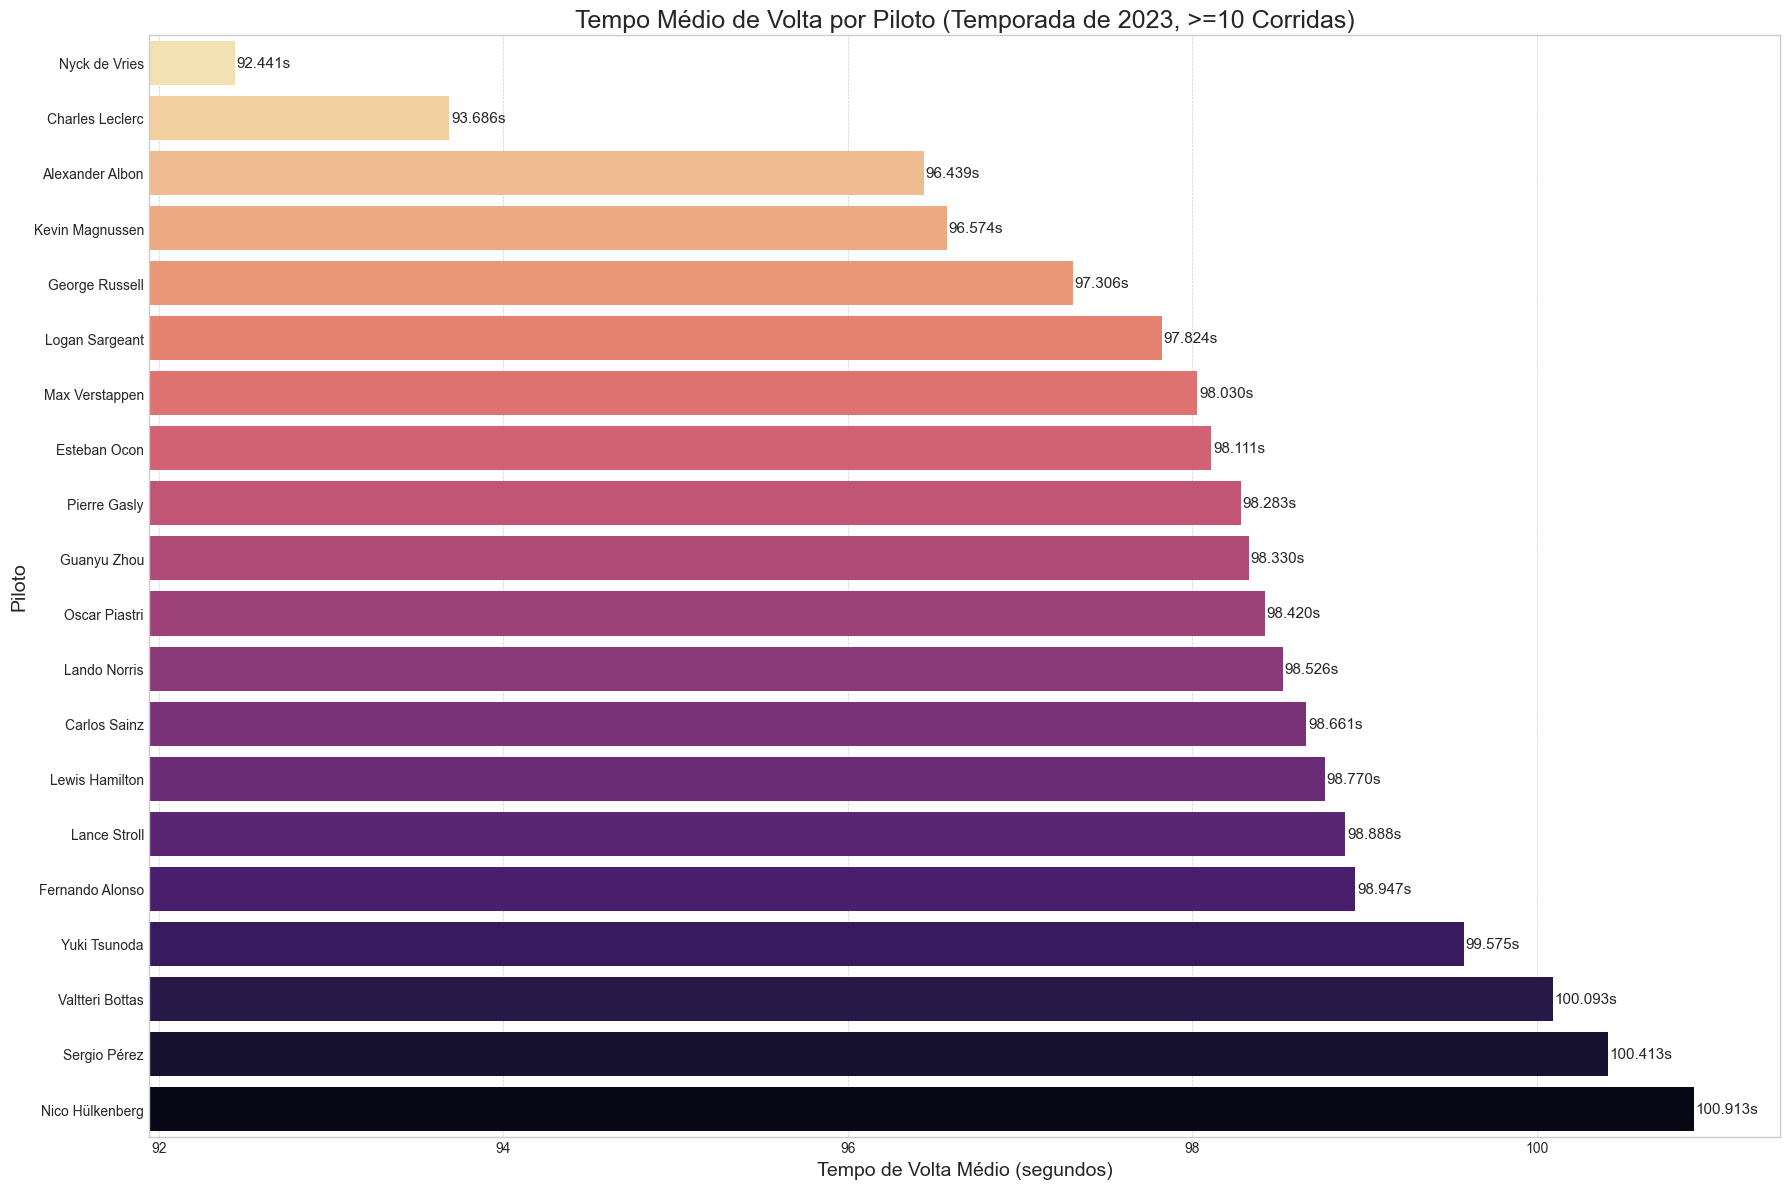

Na temporada de 2023 (considerando pilotos com >=10 corridas), o piloto mais rápido em média foi Nyck de Vries com um tempo de 92.441 segundos.


In [151]:
target_season_year = 2023

season_races = dataframes['races'].filter(col("year") == target_season_year).select("raceId")

season_results = dataframes['results'].join(season_races, "raceId", "inner")

races_per_driver = season_results.groupBy("driverId") \
    .agg(count("raceId").alias("races_participated"))

full_season_drivers = races_per_driver.filter(col("races_participated") >= 10).select("driverId")

season_lap_times = dataframes['lap_times'].join(season_races, "raceId", "inner")

filtered_lap_times = season_lap_times.join(full_season_drivers, "driverId", "inner")

avg_lap_time_df = filtered_lap_times.groupBy('driverId').agg(avg('milliseconds').alias('avg_milliseconds'))

drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
avg_lap_time_with_driver = avg_lap_time_df.join(drivers_with_label, 'driverId') \
    .withColumn('avg_seconds', col('avg_milliseconds') / 1000) \
    .orderBy('avg_seconds')

plot_data_season_filtered = avg_lap_time_with_driver.select('driver_name', 'avg_seconds').toPandas()

plt.figure(figsize=(18, 12))
ax = sns.barplot(
    x='avg_seconds',
    y='driver_name',
    data=plot_data_season_filtered,
    orient='h',
    palette='magma_r',
    hue='driver_name',
    legend=False
)

for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 0.01,
        p.get_y() + p.get_height() / 2.,
        f'{width:.3f}s',
        va='center',
        fontsize=11
    )

plt.title(f'Tempo Médio de Volta por Piloto (Temporada de {target_season_year}, >=10 Corridas)', fontsize=18)
plt.xlabel('Tempo de Volta Médio (segundos)', fontsize=14)
plt.ylabel('Piloto', fontsize=14)

min_time = plot_data_season_filtered['avg_seconds'].min()
max_time = plot_data_season_filtered['avg_seconds'].max()
plt.xlim(left=min_time - 0.5, right=max_time + 0.5)

plt.grid(True, which='major', linestyle='--', linewidth=0.5, axis='x')
plt.tight_layout()
plt.show()

fastest_driver_season = plot_data_season_filtered.iloc[0]
print(f"Na temporada de {target_season_year} (considerando pilotos com >=10 corridas), o piloto mais rápido em média foi {fastest_driver_season['driver_name']} com um tempo de {fastest_driver_season['avg_seconds']:.3f} segundos.")

### Gráfico 2 Principais pilotos com voltas mais rapidas por temporada

- **Objetivo do gráfico:** Visualizar o domínio de pilotos em voltas rápidas ao longo das temporadas.
- **Dados utilizados:** Usa as tabelas 'lap_times', 'races' e 'drivers' para cruzar tempos, anos e nomes.
- **Ações principais:** Conta voltas rápidas por piloto/ano, seleciona o top 12 e plota em barras empilhadas.
- **Saída:** Gráfico de barras empilhadas (Top 12) e um print no console com o líder geral da história.
- **Insight esperado:** Evidenciar as diferentes "eras" de domínio de pilotos específicos no esporte.
- **Complemento útil:** Facilita a correlação do desempenho dos pilotos com mudanças de regras ou de equipes.


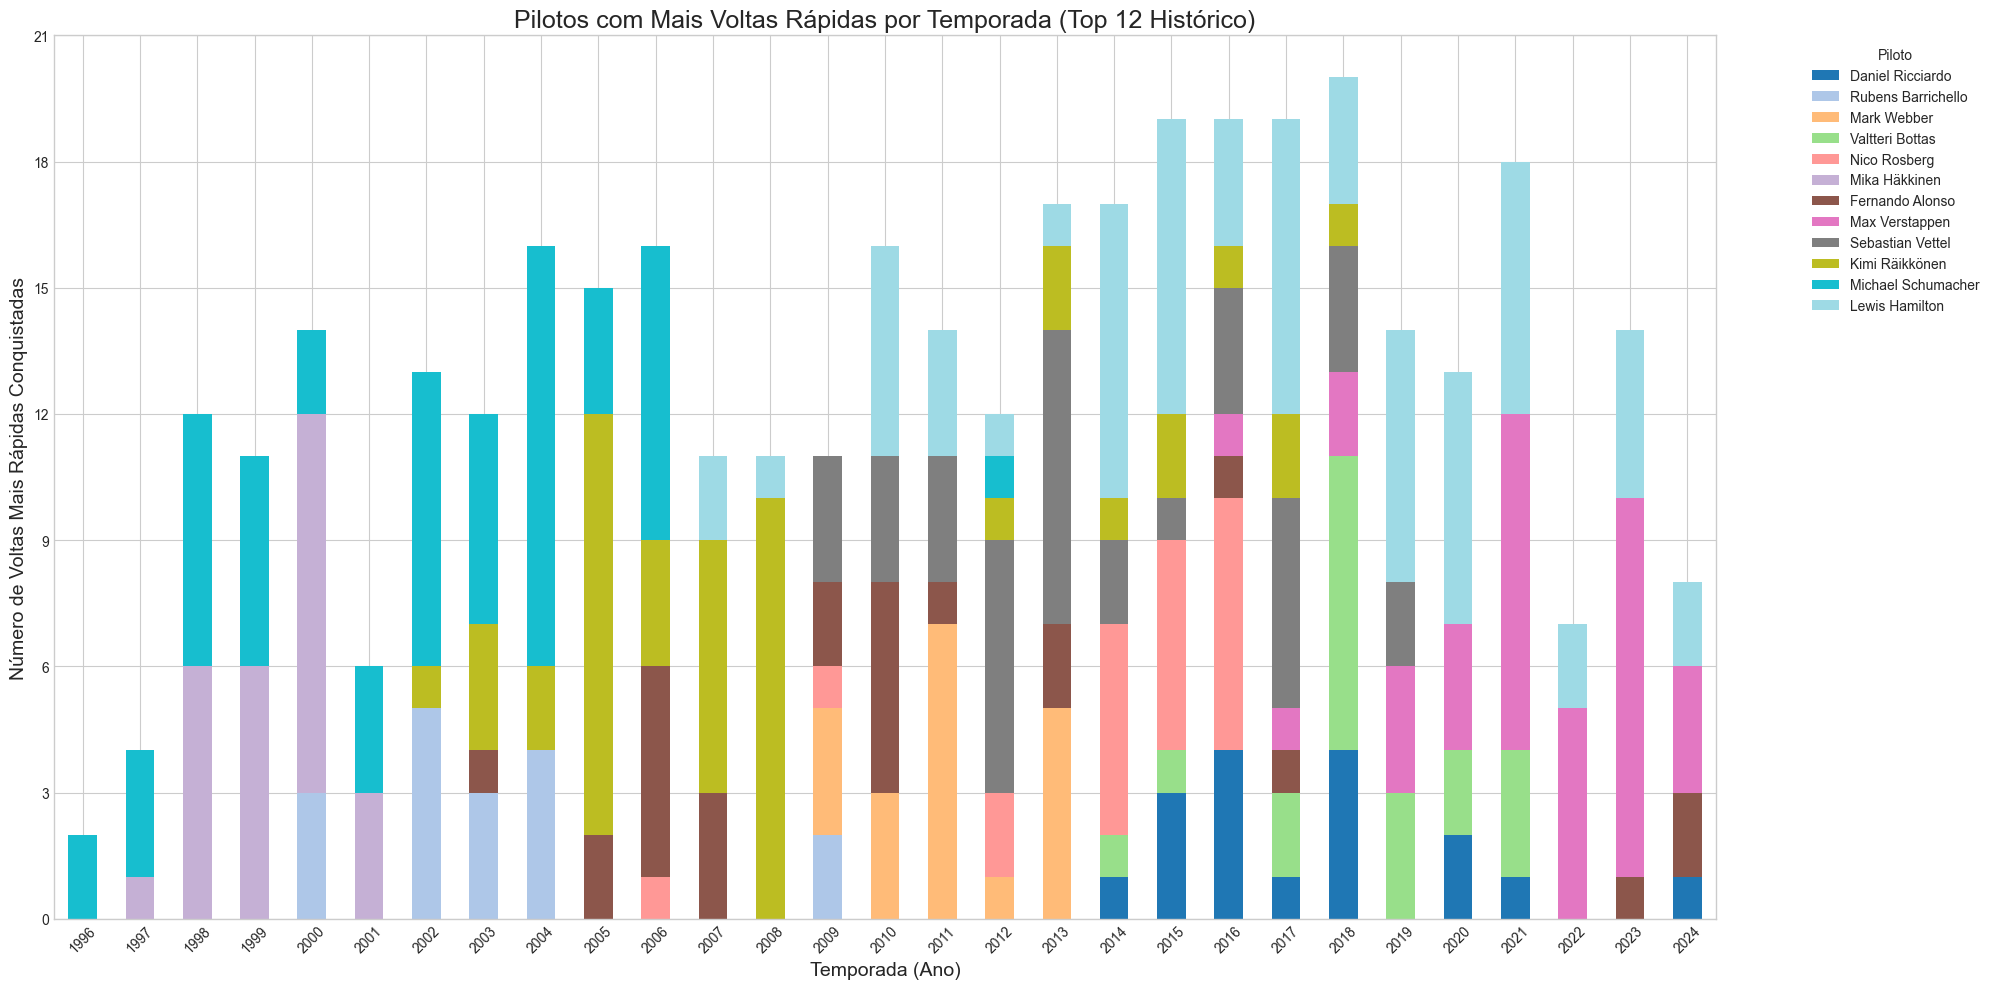

O piloto com mais voltas rápidas na história (presente nos dados) é Lewis Hamilton, com um total de 66 voltas rápidas.


In [190]:
fastest_lap_time_per_race = dataframes['lap_times'].groupBy("raceId").agg(min("milliseconds").alias("fastest_lap_ms"))

fastest_lap_driver_per_race = dataframes['lap_times'].join(fastest_lap_time_per_race, "raceId").filter(col("milliseconds") == col("fastest_lap_ms")).select("raceId", "driverId")

drivers_with_label = dataframes['drivers'].withColumn("driver_name", concat_ws(" ", col("forename"), col("surname")))

fastest_laps_summary = fastest_lap_driver_per_race.join(dataframes['races'], "raceId").join(drivers_with_label, "driverId").select("year", "driver_name")

fastest_lap_counts = fastest_laps_summary.groupBy("year", "driver_name").agg(count("*").alias("fastest_lap_count")).orderBy("year", "fastest_lap_count")

plot_data_stacked = fastest_lap_counts.toPandas()

driver_totals = plot_data_stacked.groupby('driver_name')['fastest_lap_count'].sum()
top_12_names = driver_totals.nlargest(12).index
sorted_top_12_totals = driver_totals[top_12_names].sort_values(ascending=True)
plot_order = sorted_top_12_totals.index.tolist()

plot_data_filtered = plot_data_stacked[plot_data_stacked['driver_name'].isin(plot_order)]

pivot_df = plot_data_filtered.pivot(index='year', columns='driver_name', values='fastest_lap_count').fillna(0)
pivot_df = pivot_df[plot_order]

ax = pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 10),
    colormap='tab20'
)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Pilotos com Mais Voltas Rápidas por Temporada (Top 12 Histórico)', fontsize=18)
plt.xlabel('Temporada (Ano)', fontsize=14)
plt.ylabel('Número de Voltas Mais Rápidas Conquistadas', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Piloto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

overall_leader = driver_totals.nlargest(1).index[0]
overall_count = driver_totals.nlargest(1).values[0]

print(f"O piloto com mais voltas rápidas na história (presente nos dados) é {overall_leader}, com um total de {overall_count} voltas rápidas.")

### Gráfico 3 Consistência vs velocidade de pilotos

- **Objetivo do gráfico:** Relacionar velocidade média das voltas com consistência (baixa variabilidade) dos pilotos mais atuantes.
- **Dados utilizados:** `lap_times` para média e desvio padrão por piloto/corrida e `drivers` para rotular os participantes.
- **Ações principais:** Agrupa por corrida e piloto, calculando média e desvio padrão; descarta casos sem variância; seleciona os 15 pilotos mais presentes; converte valores para segundos; gera gráfico de dispersão e calcula o piloto de menor desvio médio.
- **Saída:** Gráfico `Consistência vs. Velocidade Média por Piloto` e mensagem destacando o piloto mais consistente.
- **Insight esperado:** Distinguir pilotos velozes porém instáveis daqueles que combinam rapidez com regularidade.
- **Possíveis extensões:** Incluir tamanho do marcador proporcional ao número de corridas para contextualizar experiência.


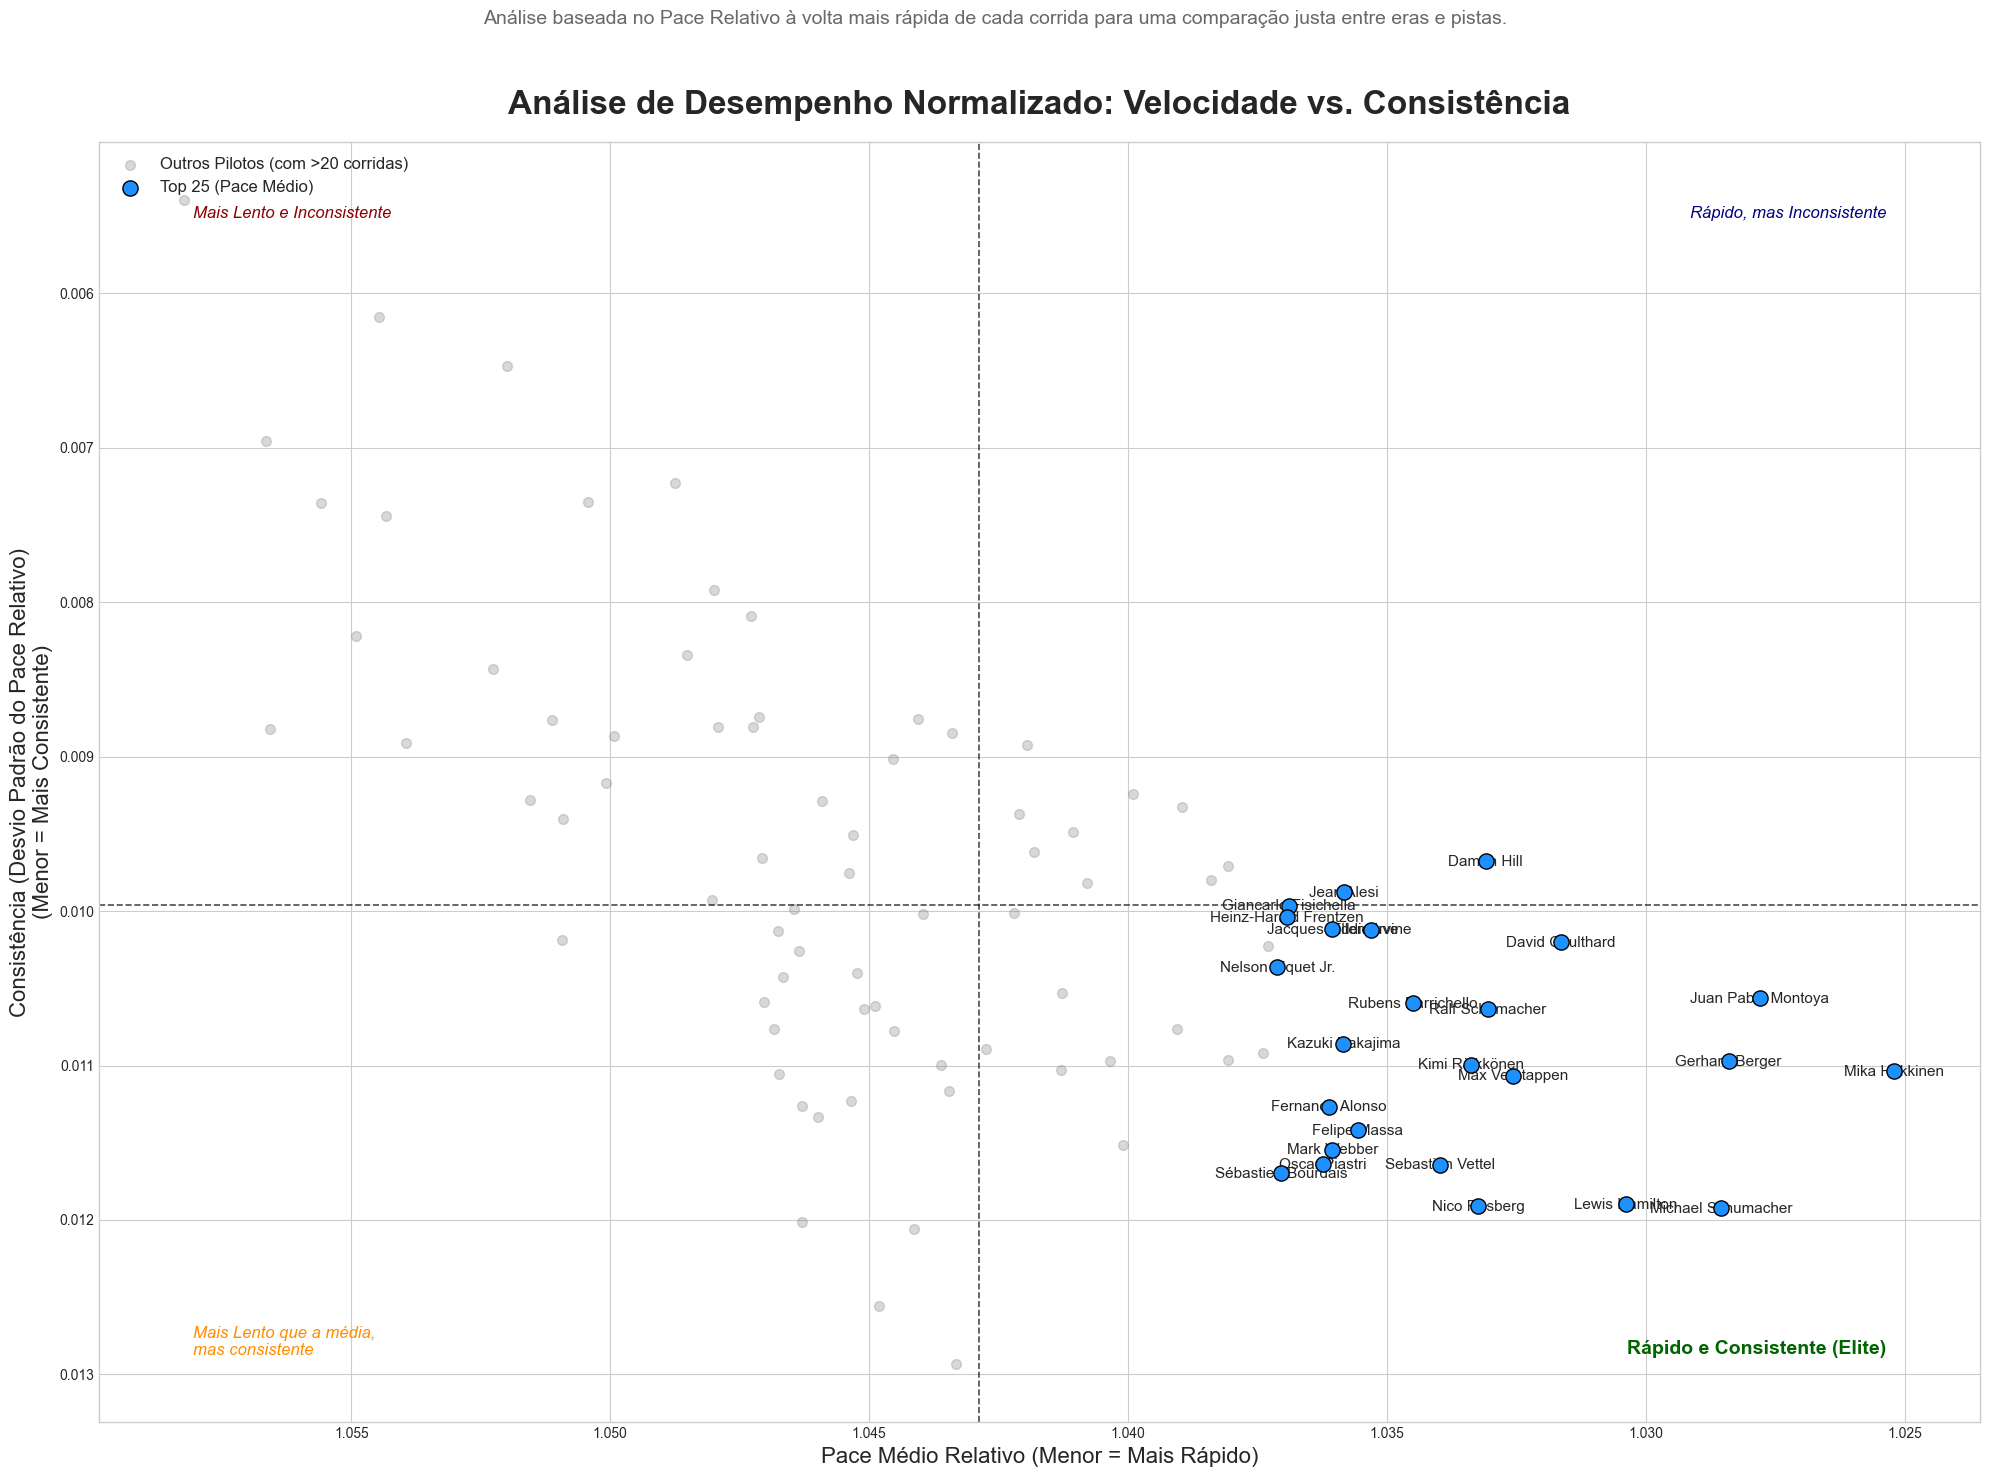


--- Análise Aprofundada dos Resultados ---
Com base em pilotos com pelo menos 20 corridas, a média do pace relativo é 1.0429 e a média da consistência é 0.00996.

### Detalhes: Top 25 Pilotos por Pace Médio Relativo


,Piloto,Pace Médio Relativo,Consistência (std),Nº de Corridas
0,Mika Häkkinen,1.02520,0.01104,91
1,Juan Pablo Montoya,1.02781,0.01057,89
2,Gerhard Berger,1.02841,0.01097,27
3,Michael Schumacher,1.02855,0.01192,228
4,Lewis Hamilton,1.03039,0.01190,345
5,David Coulthard,1.03165,0.01020,202
6,Max Verstappen,1.03256,0.01107,198
7,Ralf Schumacher,1.03306,0.01064,167
8,Damon Hill,1.03309,0.00968,59
9,Nico Rosberg,1.03324,0.01191,194


In [188]:
spark.conf.set("spark.sql.shuffle.partitions", 200)

fastest_lap_per_race = dataframes['lap_times'].groupBy('raceId').agg(min('milliseconds').alias('fastest_lap_in_race_ms'))

laps_with_benchmark = dataframes['lap_times'].join(fastest_lap_per_race, 'raceId')

laps_with_benchmark = laps_with_benchmark.withColumn(
    'relative_pace',
    col('milliseconds') / col('fastest_lap_in_race_ms')
).filter(col('relative_pace') <= 1.07)

driver_consistency_per_race_df = laps_with_benchmark.groupBy('raceId', 'driverId').agg(
    avg('relative_pace').alias('avg_relative_pace'),
    stddev('relative_pace').alias('stddev_relative_pace')
).filter(col('stddev_relative_pace').isNotNull())

drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
full_consistency_df = driver_consistency_per_race_df.join(drivers_with_label, 'driverId')

driver_overall_stats = full_consistency_df.groupBy('driver_name').agg(
    avg('avg_relative_pace').alias('overall_avg_pace'),
    avg('stddev_relative_pace').alias('overall_consistency_stddev'),
    count('raceId').alias('race_count')
)

plot_data_pd = driver_overall_stats.filter(col('race_count') >= 20).toPandas()

mean_pace = plot_data_pd['overall_avg_pace'].mean()
mean_consistency = plot_data_pd['overall_consistency_stddev'].mean()
chart_data = plot_data_pd.sort_values('overall_avg_pace', ascending=True).head(25)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(20, 16))

ax.scatter(plot_data_pd['overall_avg_pace'], plot_data_pd['overall_consistency_stddev'],
           color='gray', alpha=0.3, s=50, label='Outros Pilotos (com >20 corridas)')
ax.scatter(chart_data['overall_avg_pace'], chart_data['overall_consistency_stddev'],
           color='dodgerblue', s=120, zorder=5, ec='black', label='Top 25 (Pace Médio)')

ax.axvline(mean_pace, color='black', linestyle='--', linewidth=1.2, alpha=0.7)
ax.axhline(mean_consistency, color='black', linestyle='--', linewidth=1.2, alpha=0.7)

for i, row in chart_data.iterrows():
    ax.text(row['overall_avg_pace'], row['overall_consistency_stddev'] + 0.00005,
            row['driver_name'], fontsize=11, ha='center', va='bottom')

ax.set_title('Análise de Desempenho Normalizado: Velocidade vs. Consistência', fontsize=24, weight='bold', pad=20)
ax.set_xlabel('Pace Médio Relativo (Menor = Mais Rápido)', fontsize=16)
ax.set_ylabel('Consistência (Desvio Padrão do Pace Relativo)\n(Menor = Mais Consistente)', fontsize=16)

ax.text(0.95, 0.05, 'Rápido e Consistente (Elite)', fontsize=14, weight='bold', color='darkgreen', ha='right', va='bottom', transform=ax.transAxes)
ax.text(0.05, 0.05, 'Mais Lento que a média,\nmas consistente', fontsize=12, style='italic', color='darkorange', ha='left', va='bottom', transform=ax.transAxes)
ax.text(0.95, 0.95, 'Rápido, mas Inconsistente', fontsize=12, style='italic', color='navy', ha='right', va='top', transform=ax.transAxes)
ax.text(0.05, 0.95, 'Mais Lento e Inconsistente', fontsize=12, style='italic', color='darkred', ha='left', va='top', transform=ax.transAxes)

fig.suptitle('Análise baseada no Pace Relativo à volta mais rápida de cada corrida para uma comparação justa entre eras e pistas.',
             y=0.92, fontsize=14, color='dimgray')

ax.invert_yaxis()
ax.invert_xaxis()

ax.legend(fontsize=12, loc='upper left')
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

elite_drivers = chart_data[
    (chart_data['overall_avg_pace'] < mean_pace) &
    (chart_data['overall_consistency_stddev'] < mean_consistency)
]
elite_drivers_sorted = elite_drivers.sort_values('overall_avg_pace')
print("\n--- Análise Aprofundada dos Resultados ---")
print(f"Com base em pilotos com pelo menos 20 corridas, a média do pace relativo é {mean_pace:.4f} e a média da consistência é {mean_consistency:.5f}.")
print("\n### Detalhes: Top 25 Pilotos por Pace Médio Relativo")
table_data = chart_data[['driver_name', 'overall_avg_pace', 'overall_consistency_stddev', 'race_count']].rename(columns={
    'driver_name': 'Piloto',
    'overall_avg_pace': 'Pace Médio Relativo',
    'overall_consistency_stddev': 'Consistência (std)',
    'race_count': 'Nº de Corridas'
})
table_data['Pace Médio Relativo'] = table_data['Pace Médio Relativo'].map('{:.5f}'.format)
table_data['Consistência (std)'] = table_data['Consistência (std)'].map('{:.5f}'.format)
display(table_data.reset_index(drop=True))

### Gráfico 4 Evolução média de pilotos dentro da temporada

**Objetivo do gráfico:**  
Comparar o *pace médio relativo* de Hamilton e Verstappen em cada corrida da temporada 2021.

**Dados utilizados:**  
Usa `lap_times`, `races` e `drivers` para analisar os dados de pace dos dois pilotos em 2021.

**Ações principais:**  
- Calcula o *pace médio normalizado* por corrida para cada piloto.  
- Plota a evolução em um gráfico de linha.

**Saída:**  
Gráfico de linha comparativo e um resumo no console sobre quem foi mais rápido na temporada.

**Insight esperado:**  
Visualizar a flutuação de performance e o domínio de cada piloto durante a acirrada disputa pelo título.

**Complemento útil:**  
A análise pode ser expandida para correlacionar o pace com incidentes de corrida ou tipos de pista.


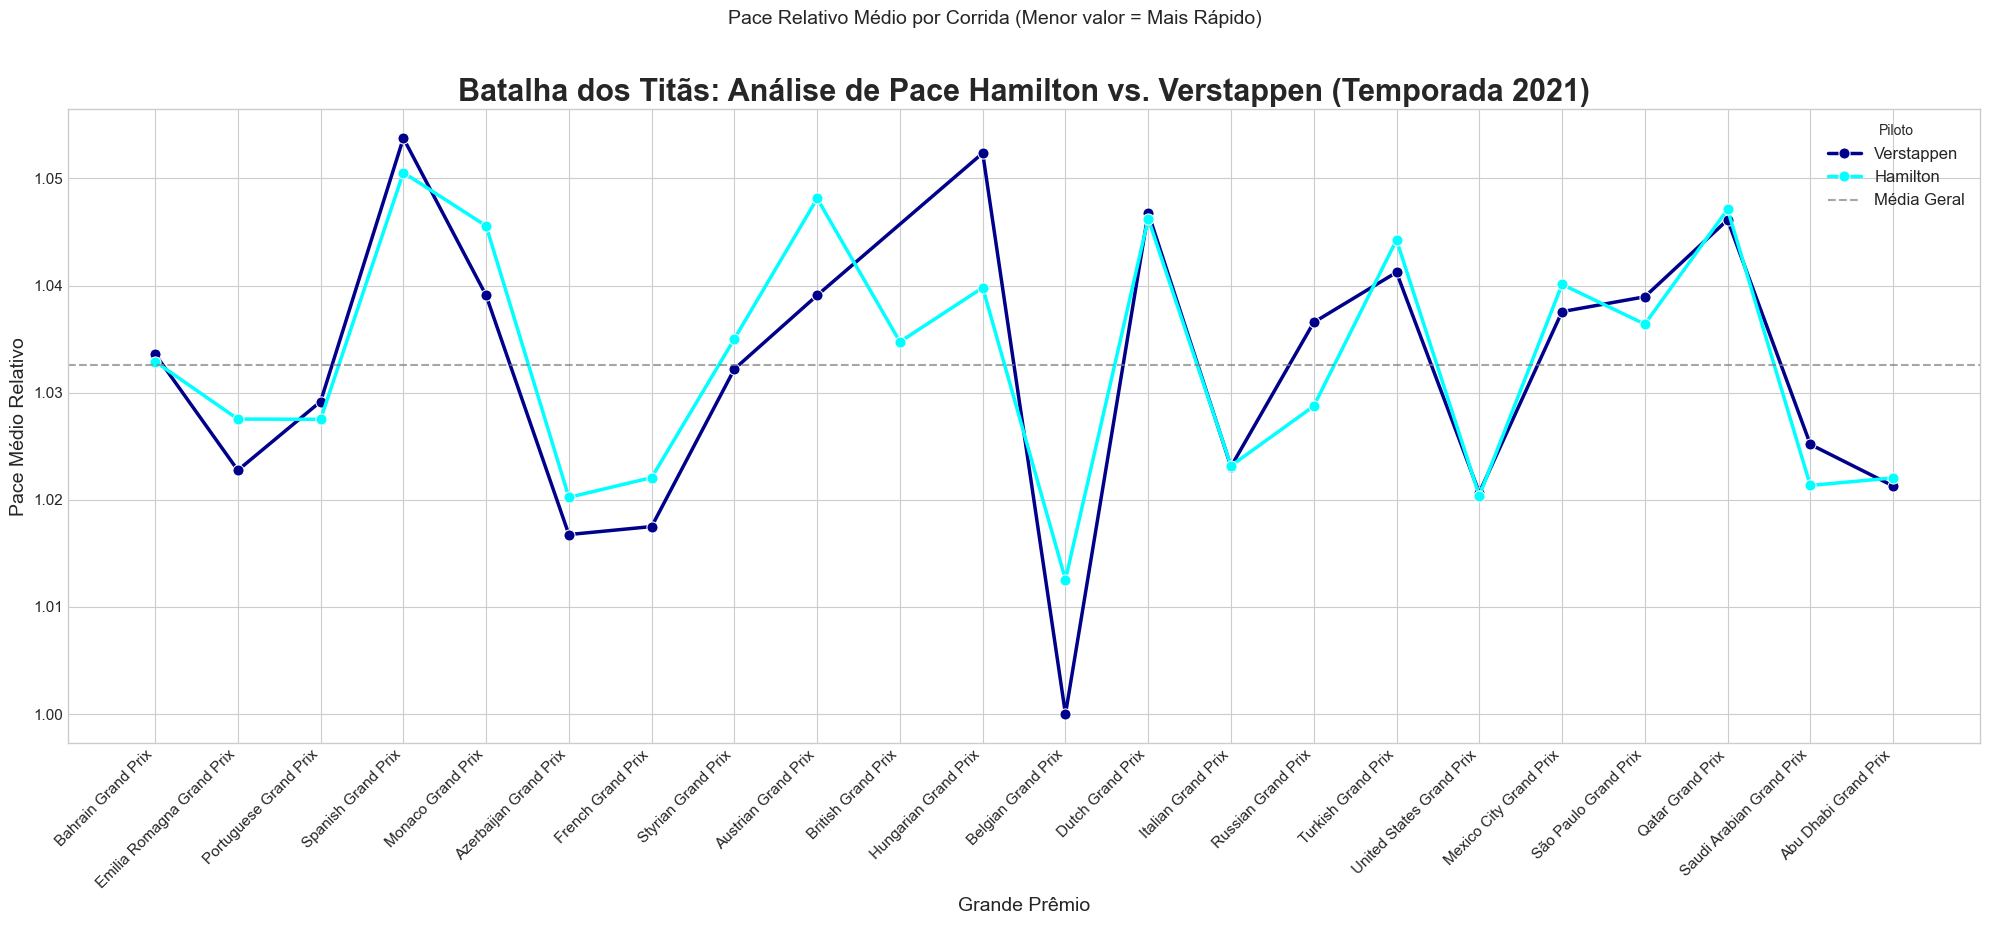


### Detalhes: Comparativo de Pace por Corrida (2021)


,Grande Prêmio,Pace Verstappen,Pace Hamilton,Mais Rápido
0,Bahrain Grand Prix,1.03361,1.03291,Hamilton
1,Emilia Romagna Grand Prix,1.02276,1.02754,Verstappen
2,Portuguese Grand Prix,1.02917,1.02752,Hamilton
3,Spanish Grand Prix,1.05376,1.05055,Hamilton
4,Monaco Grand Prix,1.03908,1.04557,Verstappen
5,Azerbaijan Grand Prix,1.01676,1.02023,Verstappen
6,French Grand Prix,1.01750,1.02207,Verstappen
7,Styrian Grand Prix,1.03221,1.03503,Verstappen
8,Austrian Grand Prix,1.03909,1.04813,Verstappen
9,Hungarian Grand Prix,1.05236,1.03980,Hamilton



--- Análise de Desempenho: Temporada 2021 ---
Corridas em que Verstappen teve um pace médio mais rápido: 12
Corridas em que Hamilton teve um pace médio mais rápido: 9
--------------------------------------------------
Pace Relativo Médio de Verstappen na temporada: 1.03208
Pace Relativo Médio de Hamilton na temporada:    1.03302

No geral, Max Verstappen teve um pace médio ligeiramente superior ao longo da temporada 2021.


In [186]:
target_season = 2021
driver1_surname = "Verstappen"
driver2_surname = "Hamilton"

drivers_df = dataframes['drivers'].filter(
    (col('surname') == driver1_surname) | (col('surname') == driver2_surname)
).select('driverId', 'surname')

races_2021_df = dataframes['races'].filter(col('year') == target_season)

lap_times_2021_df = dataframes['lap_times'].join(races_2021_df.select('raceId'), 'raceId')
fastest_lap_per_race_2021 = lap_times_2021_df.groupBy('raceId').agg(min('milliseconds').alias('fastest_lap_in_race_ms'))

driver_laps_2021 = lap_times_2021_df.join(drivers_df, 'driverId') \
                                   .join(fastest_lap_per_race_2021, 'raceId')

driver_laps_2021 = driver_laps_2021.withColumn(
    'relative_pace',
    col('milliseconds') / col('fastest_lap_in_race_ms')
).filter(col('relative_pace') <= 1.07)

avg_pace_per_race = driver_laps_2021.groupBy('raceId', 'driverId', 'surname') \
                                     .agg(avg('relative_pace').alias('avg_relative_pace'))

final_df = avg_pace_per_race.join(races_2021_df, 'raceId') \
                             .select('round', 'name', 'surname', 'avg_relative_pace') \
                             .orderBy('round')

plot_data_comparison = final_df.toPandas()

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(20, 10))

ax = sns.lineplot(
    data=plot_data_comparison,
    x='name',
    y='avg_relative_pace',
    hue='surname',
    palette={'Verstappen': 'darkblue', 'Hamilton': 'cyan'},
    marker='o',
    markersize=8,
    linewidth=2.5
)

plt.title(f'Batalha dos Titãs: Análise de Pace Hamilton vs. Verstappen (Temporada {target_season})', fontsize=22, weight='bold')
plt.suptitle('Pace Relativo Médio por Corrida (Menor valor = Mais Rápido)', fontsize=14, y=0.92)
plt.xlabel('Grande Prêmio', fontsize=14)
plt.ylabel('Pace Médio Relativo', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)

ax.axhline(plot_data_comparison['avg_relative_pace'].mean(), ls='--', color='gray', alpha=0.7, label='Média Geral de Pace')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Verstappen', 'Hamilton', 'Média Geral'], title='Piloto', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

verstappen_pace = plot_data_comparison[plot_data_comparison['surname'] == 'Verstappen'].reset_index()
hamilton_pace = plot_data_comparison[plot_data_comparison['surname'] == 'Hamilton'].reset_index()

compare_df = pd.merge(verstappen_pace, hamilton_pace, on='round', suffixes=('_ver', '_ham'))
compare_df['faster_driver'] = compare_df.apply(lambda row: 'Verstappen' if row['avg_relative_pace_ver'] < row['avg_relative_pace_ham'] else 'Hamilton', axis=1)

print(f"\n### Detalhes: Comparativo de Pace por Corrida ({target_season})")
table_data = compare_df[['name_ham', 'avg_relative_pace_ver', 'avg_relative_pace_ham', 'faster_driver']].rename(columns={
    'name_ham': 'Grande Prêmio',
    'avg_relative_pace_ver': 'Pace Verstappen',
    'avg_relative_pace_ham': 'Pace Hamilton',
    'faster_driver': 'Mais Rápido'
})
table_data['Pace Verstappen'] = table_data['Pace Verstappen'].map('{:.5f}'.format)
table_data['Pace Hamilton'] = table_data['Pace Hamilton'].map('{:.5f}'.format)
display(table_data)
verstappen_wins = (compare_df['faster_driver'] == 'Verstappen').sum()
hamilton_wins = (compare_df['faster_driver'] == 'Hamilton').sum()
verstappen_season_avg = verstappen_pace['avg_relative_pace'].mean()
hamilton_season_avg = hamilton_pace['avg_relative_pace'].mean()
print("\n--- Análise de Desempenho: Temporada 2021 ---")
print(f"Corridas em que Verstappen teve um pace médio mais rápido: {verstappen_wins}")
print(f"Corridas em que Hamilton teve um pace médio mais rápido: {hamilton_wins}")
print("-" * 50)
print(f"Pace Relativo Médio de Verstappen na temporada: {verstappen_season_avg:.5f}")
print(f"Pace Relativo Médio de Hamilton na temporada:    {hamilton_season_avg:.5f}")

if verstappen_season_avg < hamilton_season_avg:
    print("\nNo geral, Max Verstappen teve um pace médio ligeiramente superior ao longo da temporada 2021.")
else:
    print("\nNo geral, Lewis Hamilton teve um pace médio ligeiramente superior ao longo da temporada 2021.")



### Gráfico 5: Top Pilotos por Voltas Mais Rápidas (VMR)

**Objetivo do gráfico:**  
Identificar e ranquear os pilotos com o maior número de voltas mais rápidas na história.

**Dados utilizados:**  
Usa `lap_times` para encontrar a volta mais rápida de cada corrida e `drivers` para os nomes.

**Ações principais:**  
- Encontra o autor de cada volta mais rápida.  
- Agrupa e conta por piloto.  
- Plota o *top 25* em barras.

**Saída:**  
Gráfico de barras com o ranking dos 25 melhores e um print com o líder geral no console.

**Insight esperado:**  
Destacar os pilotos com maior capacidade de atingir o pico de performance em ritmo de corrida.

**Complemento útil:**  
A contagem pode ser usada para criar métricas de eficiência (ex.: VMR por corrida disputada).


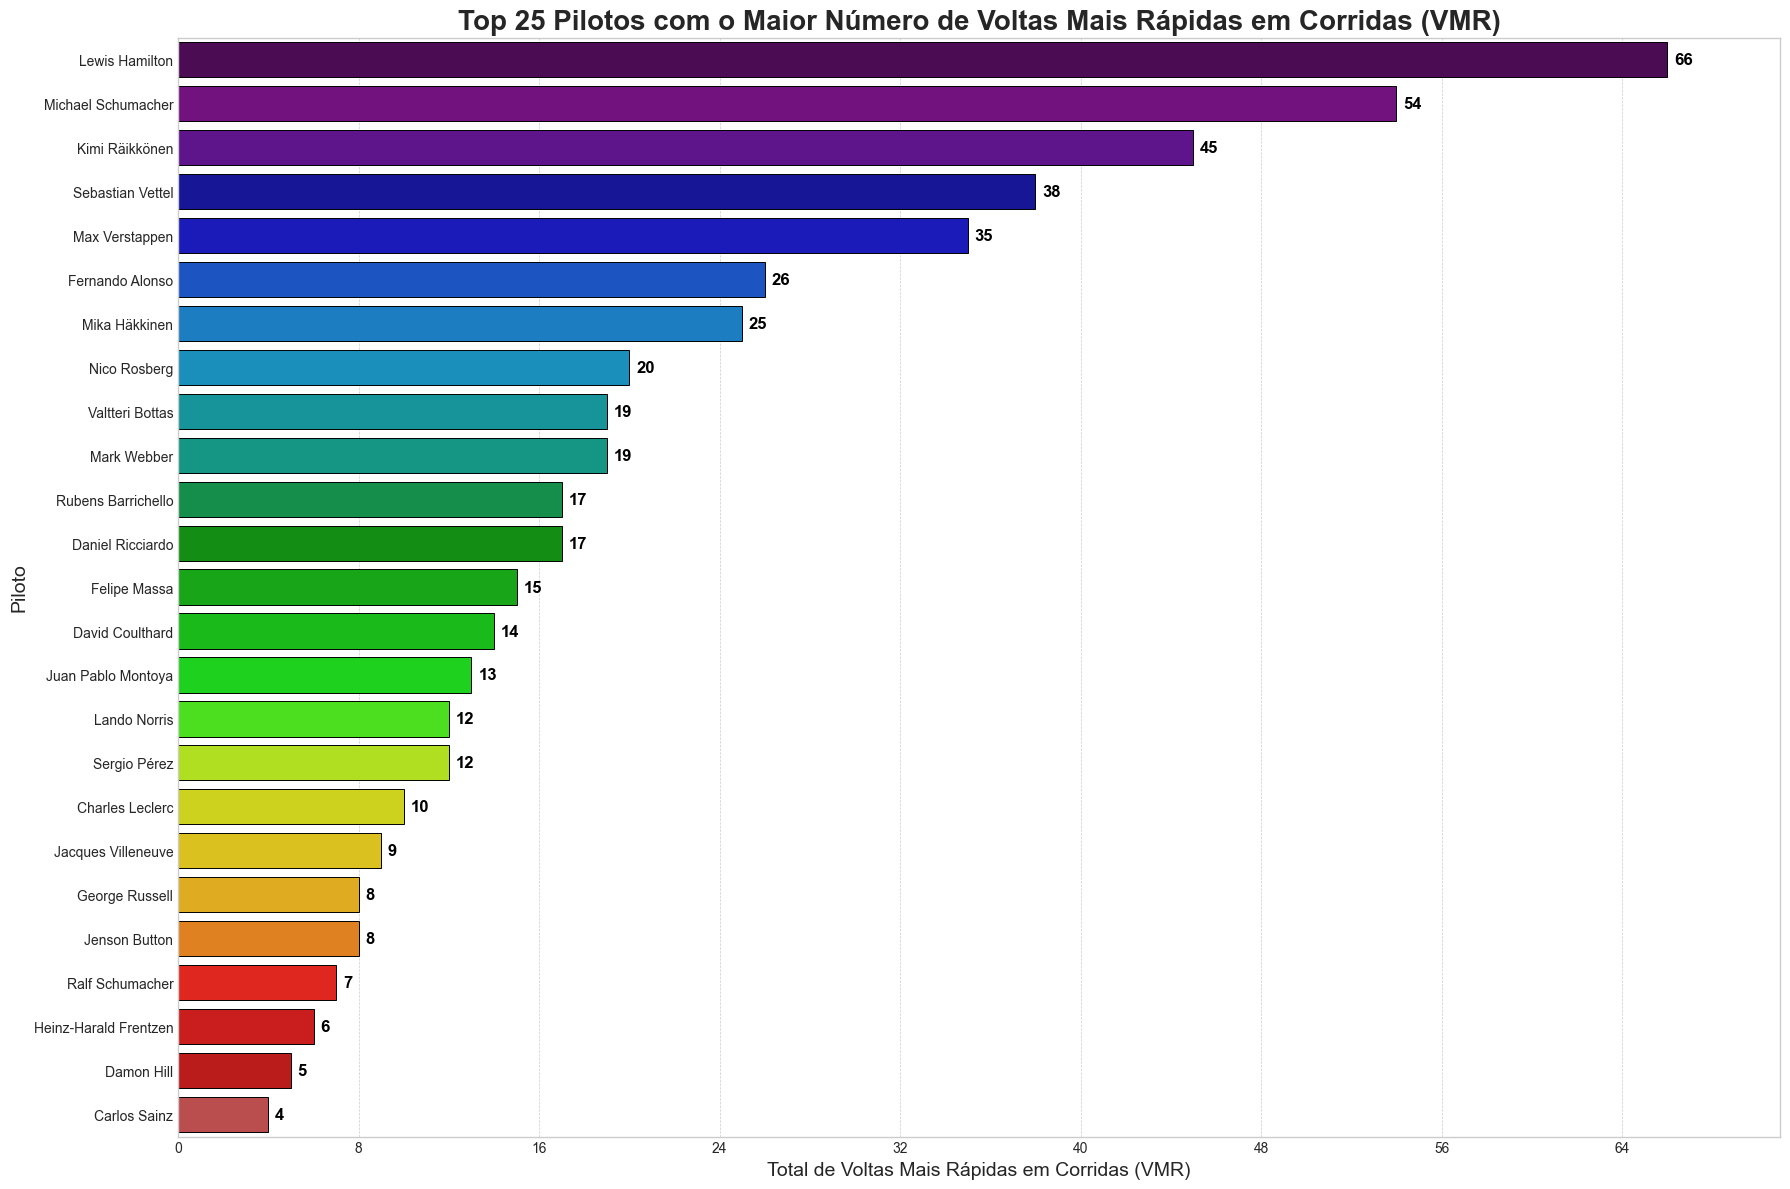

O piloto com o maior número de voltas mais rápidas em corridas (VMR) na base de dados é Lewis Hamilton com um total de 66 VMR.


In [181]:
window_spec_race = Window.partitionBy('raceId').orderBy('milliseconds')
fastest_lap_in_each_race = dataframes['lap_times'].withColumn('rank', rank().over(window_spec_race)) \
                                                  .filter(col('rank') == 1).drop('rank')

fastest_lap_counts = fastest_lap_in_each_race.groupBy('driverId').agg(count('*').alias('fastest_race_lap_count'))

drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
final_plot_data_spark = fastest_lap_counts.join(drivers_with_label, 'driverId') \
                                          .orderBy(col('fastest_race_lap_count').desc())

plot_data_pd = final_plot_data_spark.select('driver_name', 'fastest_race_lap_count').toPandas()

top_n = 25
chart_data = plot_data_pd.head(top_n)

plt.figure(figsize=(18, 12))

colors = sns.color_palette("nipy_spectral", n_colors=len(chart_data))
color_map = {driver: color for driver, color in zip(chart_data['driver_name'], colors)}

ax = sns.barplot(
    data=chart_data,
    x='fastest_race_lap_count',
    y='driver_name',
    orient='h',
    palette=color_map,
    edgecolor='black',
    linewidth=0.7,
    hue='driver_name',  
    legend=False        
)

for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 0.3,
        p.get_y() + p.get_height() / 2,
        f'{int(width)}',
        ha='left',
        va='center',
        fontsize=12,
        color='black',
        weight='bold'
    )

plt.title(f'Top {top_n} Pilotos com o Maior Número de Voltas Mais Rápidas em Corridas (VMR)', fontsize=20, weight='bold')
plt.xlabel('Total de Voltas Mais Rápidas em Corridas (VMR)', fontsize=14)
plt.ylabel('Piloto', fontsize=14)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim(right=chart_data['fastest_race_lap_count'].max() + 5)

plt.grid(True, which='major', linestyle='--', linewidth=0.5, axis='x')
plt.tight_layout()
plt.show()

most_fastest_laps_driver = plot_data_pd.iloc[0]
print(f"O piloto com o maior número de voltas mais rápidas em corridas (VMR) na base de dados é {most_fastest_laps_driver['driver_name']} com um total de {most_fastest_laps_driver['fastest_race_lap_count']} VMR.")

### Gráfico 6: Comparativo de Desempenho — Elite vs. Outras Equipes

**Objetivo do gráfico:**  
Quantificar e comparar o tempo médio de volta de pilotos que correram tanto em equipes de elite quanto em outras equipes.

**Dados utilizados:**  
`lap_times`, `results`, `constructors` e `drivers` para categorizar o desempenho por tipo de equipe.

**Ações principais:**  
- Calcula o tempo médio por categoria de equipe.  
- Filtra pilotos que competiram em ambas as categorias.  
- Calcula o ganho percentual.

**Saída:**  
Gráfico de barras agrupadas mostrando o tempo médio em cada categoria, com a % de ganho no rótulo do piloto.

**Insight esperado:**  
Mostrar quais pilotos tiveram a maior melhora de performance (ganho percentual) ao se mudarem para uma equipe de ponta.

**Complemento útil:**  
Serve como uma ferramenta para tentar isolar o talento do piloto do desempenho do carro, gerando boas discussões.


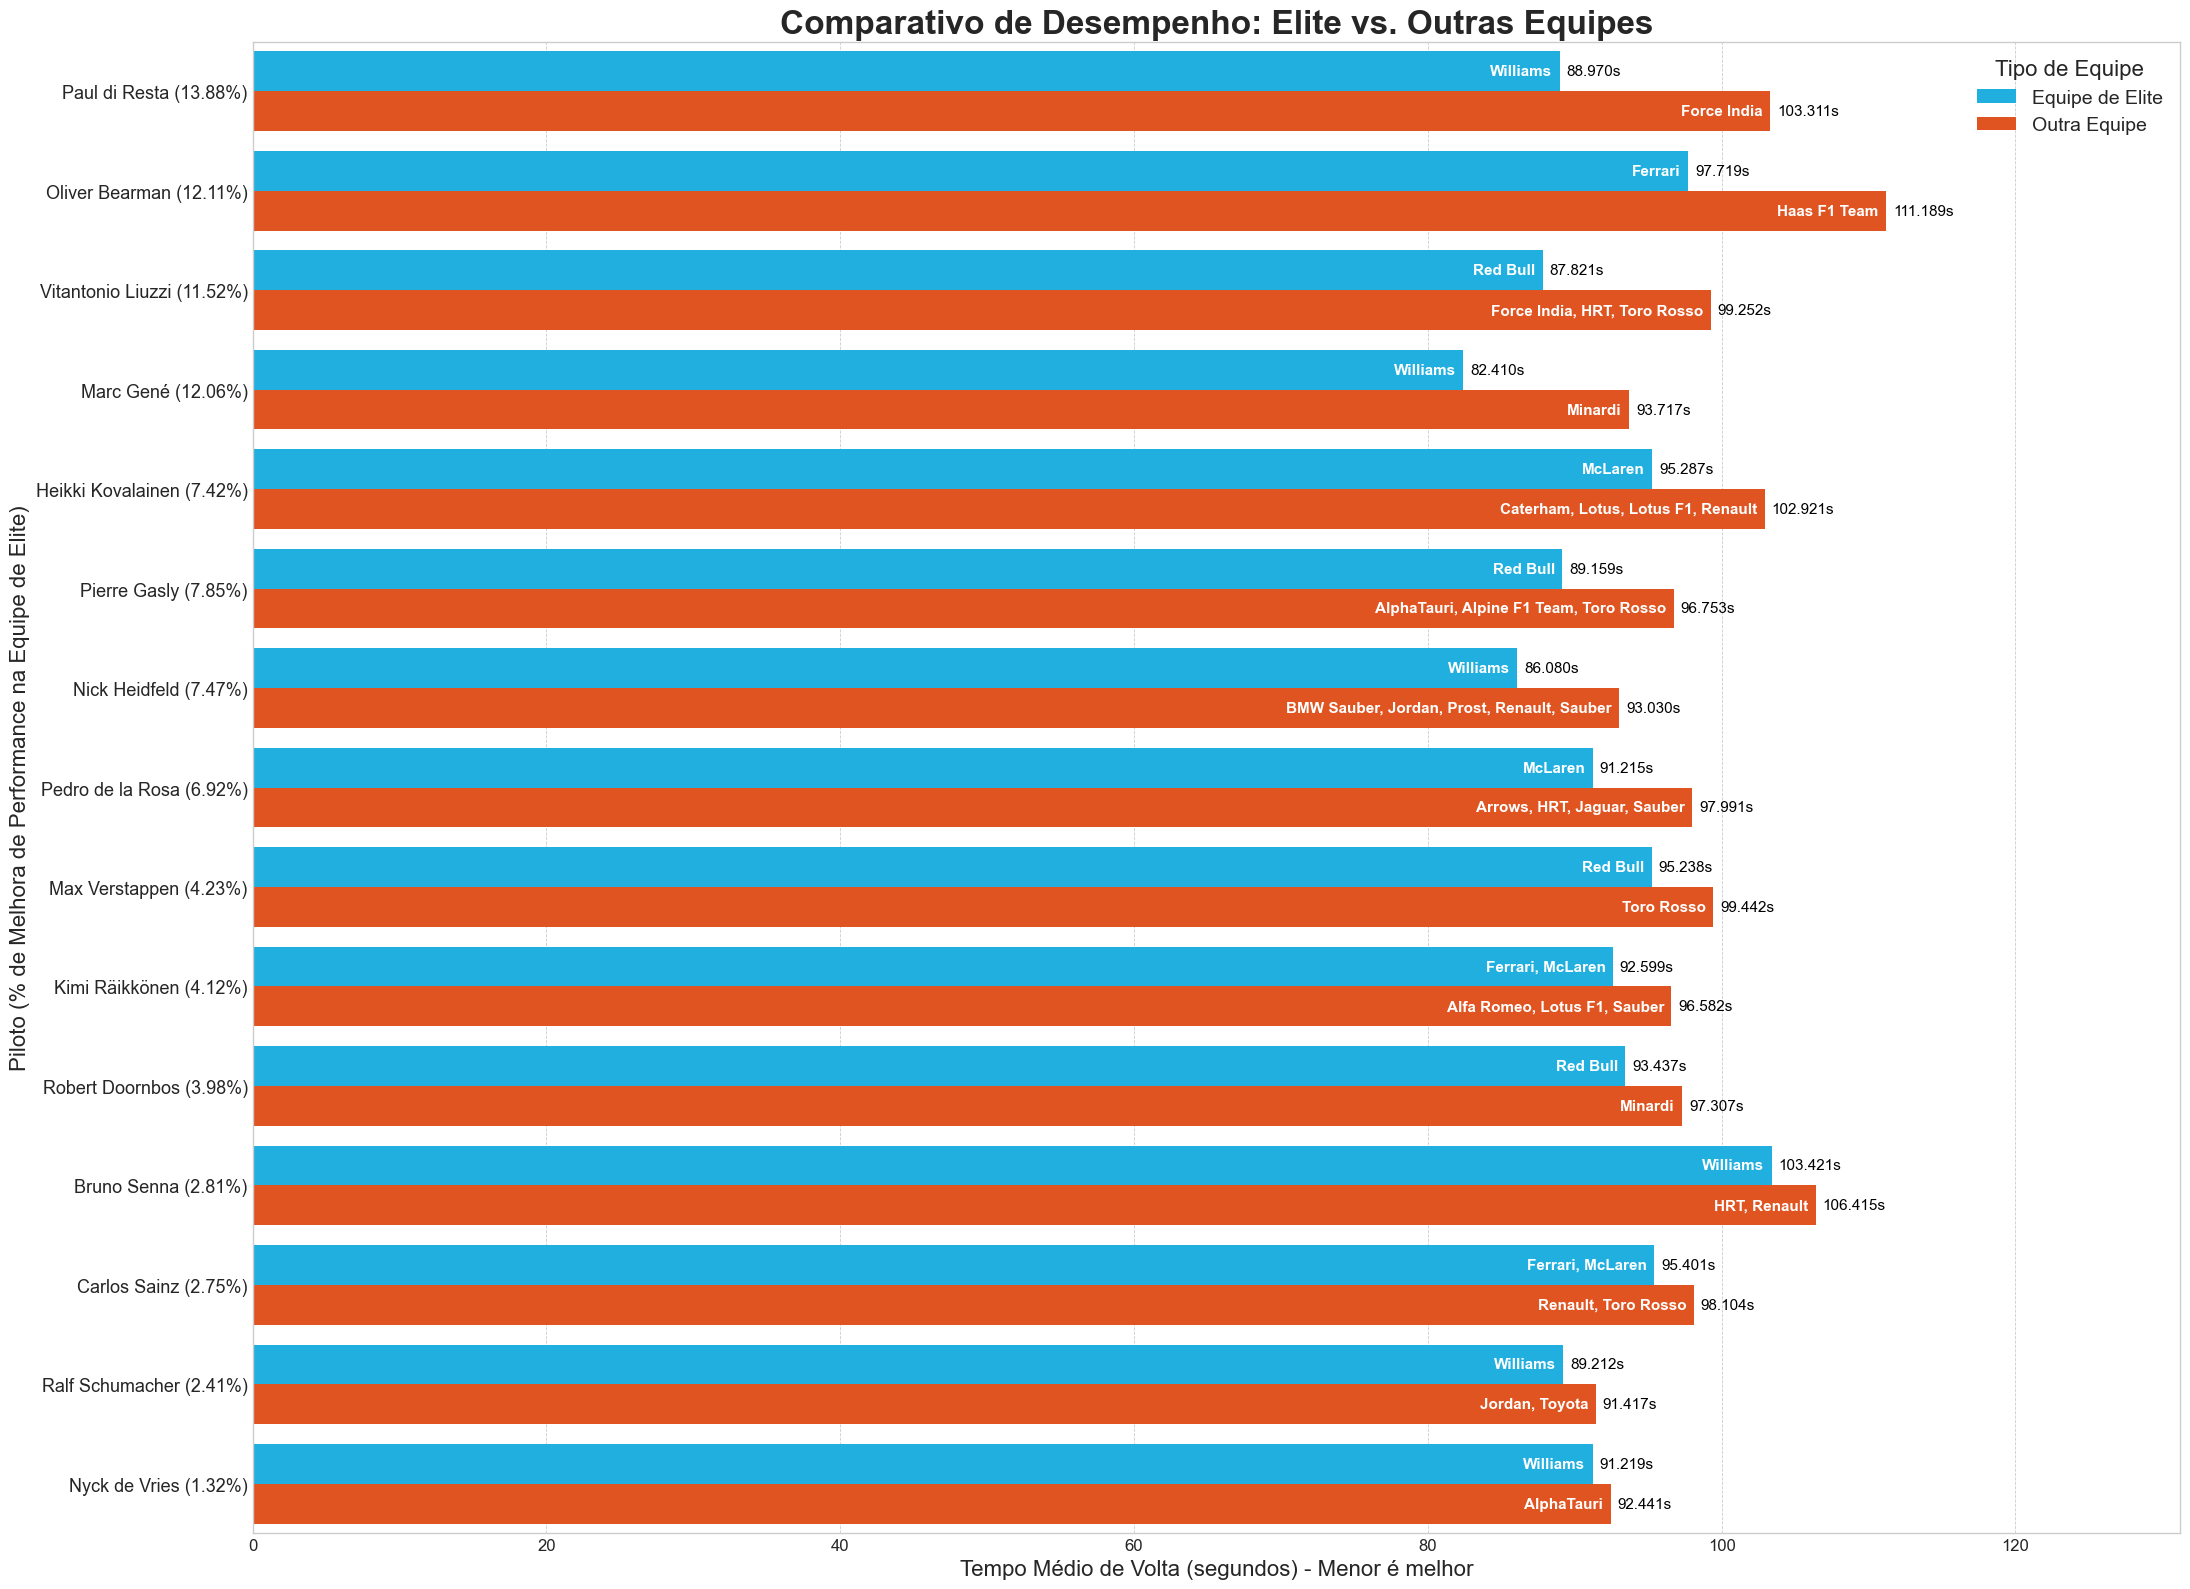

In [156]:
top_team_names = ["Ferrari", "McLaren", "Red Bull", "Mercedes", "Williams"]
top_teams_df = dataframes['constructors'].filter(F.col('name').isin(top_team_names))
top_team_ids = [row.constructorId for row in top_teams_df.select('constructorId').collect()]

results_filtered = dataframes['results'].select('raceId', 'driverId', 'constructorId').distinct()
laps_with_constructors = dataframes['lap_times'].join(results_filtered, on=['raceId', 'driverId'], how='inner')
laps_with_names = laps_with_constructors.join(dataframes['constructors'].select('constructorId', 'name'), 'constructorId')

laps_with_category = laps_with_names.withColumn(
    "team_category",
    F.when(F.col("constructorId").isin(top_team_ids), "Equipe de Elite").otherwise("Outra Equipe")
)

driver_perf_by_category = laps_with_category.groupBy('driverId', 'team_category') \
    .agg(
        (F.avg('milliseconds') / 1000).alias('avg_lap_s'),
        F.collect_set('name').alias('teams_list')
    )

drivers_with_names = dataframes['drivers'].withColumn('driver_name', F.concat_ws(' ', F.col('forename'), F.col('surname')))
driver_perf_with_names = driver_perf_by_category.join(drivers_with_names, 'driverId')

driver_category_counts = driver_perf_with_names.groupBy('driverId').count()
drivers_in_both_ids = driver_category_counts.filter(F.col('count') == 2).select('driverId')
final_df = driver_perf_with_names.join(drivers_in_both_ids, 'driverId', 'inner')

pivot_df = final_df.groupBy('driver_name').pivot('team_category').agg(F.first('avg_lap_s'))
gain_df = pivot_df.withColumn('gain', F.col('Outra Equipe') - F.col('Equipe de Elite')) \
                  .withColumn('percentage_gain', (F.col('gain') / F.col('Outra Equipe')) * 100) \
                  .orderBy(F.col('gain').desc())

plot_data_pd = final_df.join(gain_df.select('driver_name', 'gain', 'percentage_gain'), 'driver_name', 'inner') \
    .orderBy(F.col('gain').desc(), F.col('team_category')) \
    .toPandas()

plot_data_pd['teams_str'] = plot_data_pd['teams_list'].apply(lambda x: ', '.join(sorted(x)))

top_drivers_order = plot_data_pd['driver_name'].unique()[:15]
chart_data = plot_data_pd[plot_data_pd['driver_name'].isin(top_drivers_order)]
hue_order = ['Equipe de Elite', 'Outra Equipe']

percentage_map = chart_data[['driver_name', 'percentage_gain']].drop_duplicates().set_index('driver_name')['percentage_gain']
new_yticklabels = [f"{driver} ({percentage_map[driver]:.2f}%)" for driver in top_drivers_order]

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(22, 16))

sns.barplot(
    data=chart_data,
    y='driver_name',
    x='avg_lap_s',
    hue='team_category',
    orient='h',
    palette={'Equipe de Elite': '#00BFFF', 'Outra Equipe': '#FF4500'},
    ax=ax,
    order=top_drivers_order,
    hue_order=hue_order
)


for container in ax.containers:
    ax.bar_label(container, fmt='%.3fs', padding=5, fontsize=11, color='black')

for category_index, container in enumerate(ax.containers):
    category = hue_order[category_index]
    for driver_index, p in enumerate(container):
        driver_name = top_drivers_order[driver_index]
        
        row_data = chart_data[
            (chart_data['driver_name'] == driver_name) & 
            (chart_data['team_category'] == category)
        ]
        
        if not row_data.empty:
            teams_string = row_data.iloc[0]['teams_str']
            width = p.get_width()

            if width > 10:
                ax.text(width - 0.5, 
                        p.get_y() + p.get_height() / 2,
                        teams_string,
                        ha='right',
                        va='center',
                        color='white',
                        fontsize=11,
                        weight='bold')

ax.set_title('Comparativo de Desempenho: Elite vs. Outras Equipes', fontsize=24, weight='bold')
ax.set_xlabel('Tempo Médio de Volta (segundos) - Menor é melhor', fontsize=16)
ax.set_ylabel('Piloto (% de Melhora de Performance na Equipe de Elite)', fontsize=16)

ax.set_yticks(range(len(top_drivers_order)))
ax.set_yticklabels(new_yticklabels)

ax.tick_params(axis='y', labelsize=13)
ax.tick_params(axis='x', labelsize=12)
ax.set_xlim(right=chart_data['avg_lap_s'].max() * 1.18)
ax.legend(title='Tipo de Equipe', fontsize=14, title_fontsize=16)
ax.grid(True, which='major', linestyle='--', linewidth=0.6, axis='x')

plt.tight_layout()
plt.show()

### Gráfico 7 Posição média de pilotos experientes

- **Objetivo do gráfico:** Comparar a posição média de chegada entre pilotos com grande volume de voltas acumuladas.
- **Dados utilizados:** `lap_times` para posições e contagem de voltas, `drivers` para rotular.
- **Ações principais:** Filtra pilotos com mais de 2000 voltas, calcula a posição média, associa nomes, ordena, converte para Pandas e plota o Top 25.
- **Saída:** Gráfico `Posição Média em Corrida por Piloto (com mais de 2000 voltas)` e mensagem com o piloto de melhor média.
- **Insight esperado:** Destacar competidores que se mantêm regularmente nas primeiras posições quando têm amostra representativa.
- **Consideração adicional:** Cruzar com equipes ou períodos históricos para contextualizar a média encontrada.


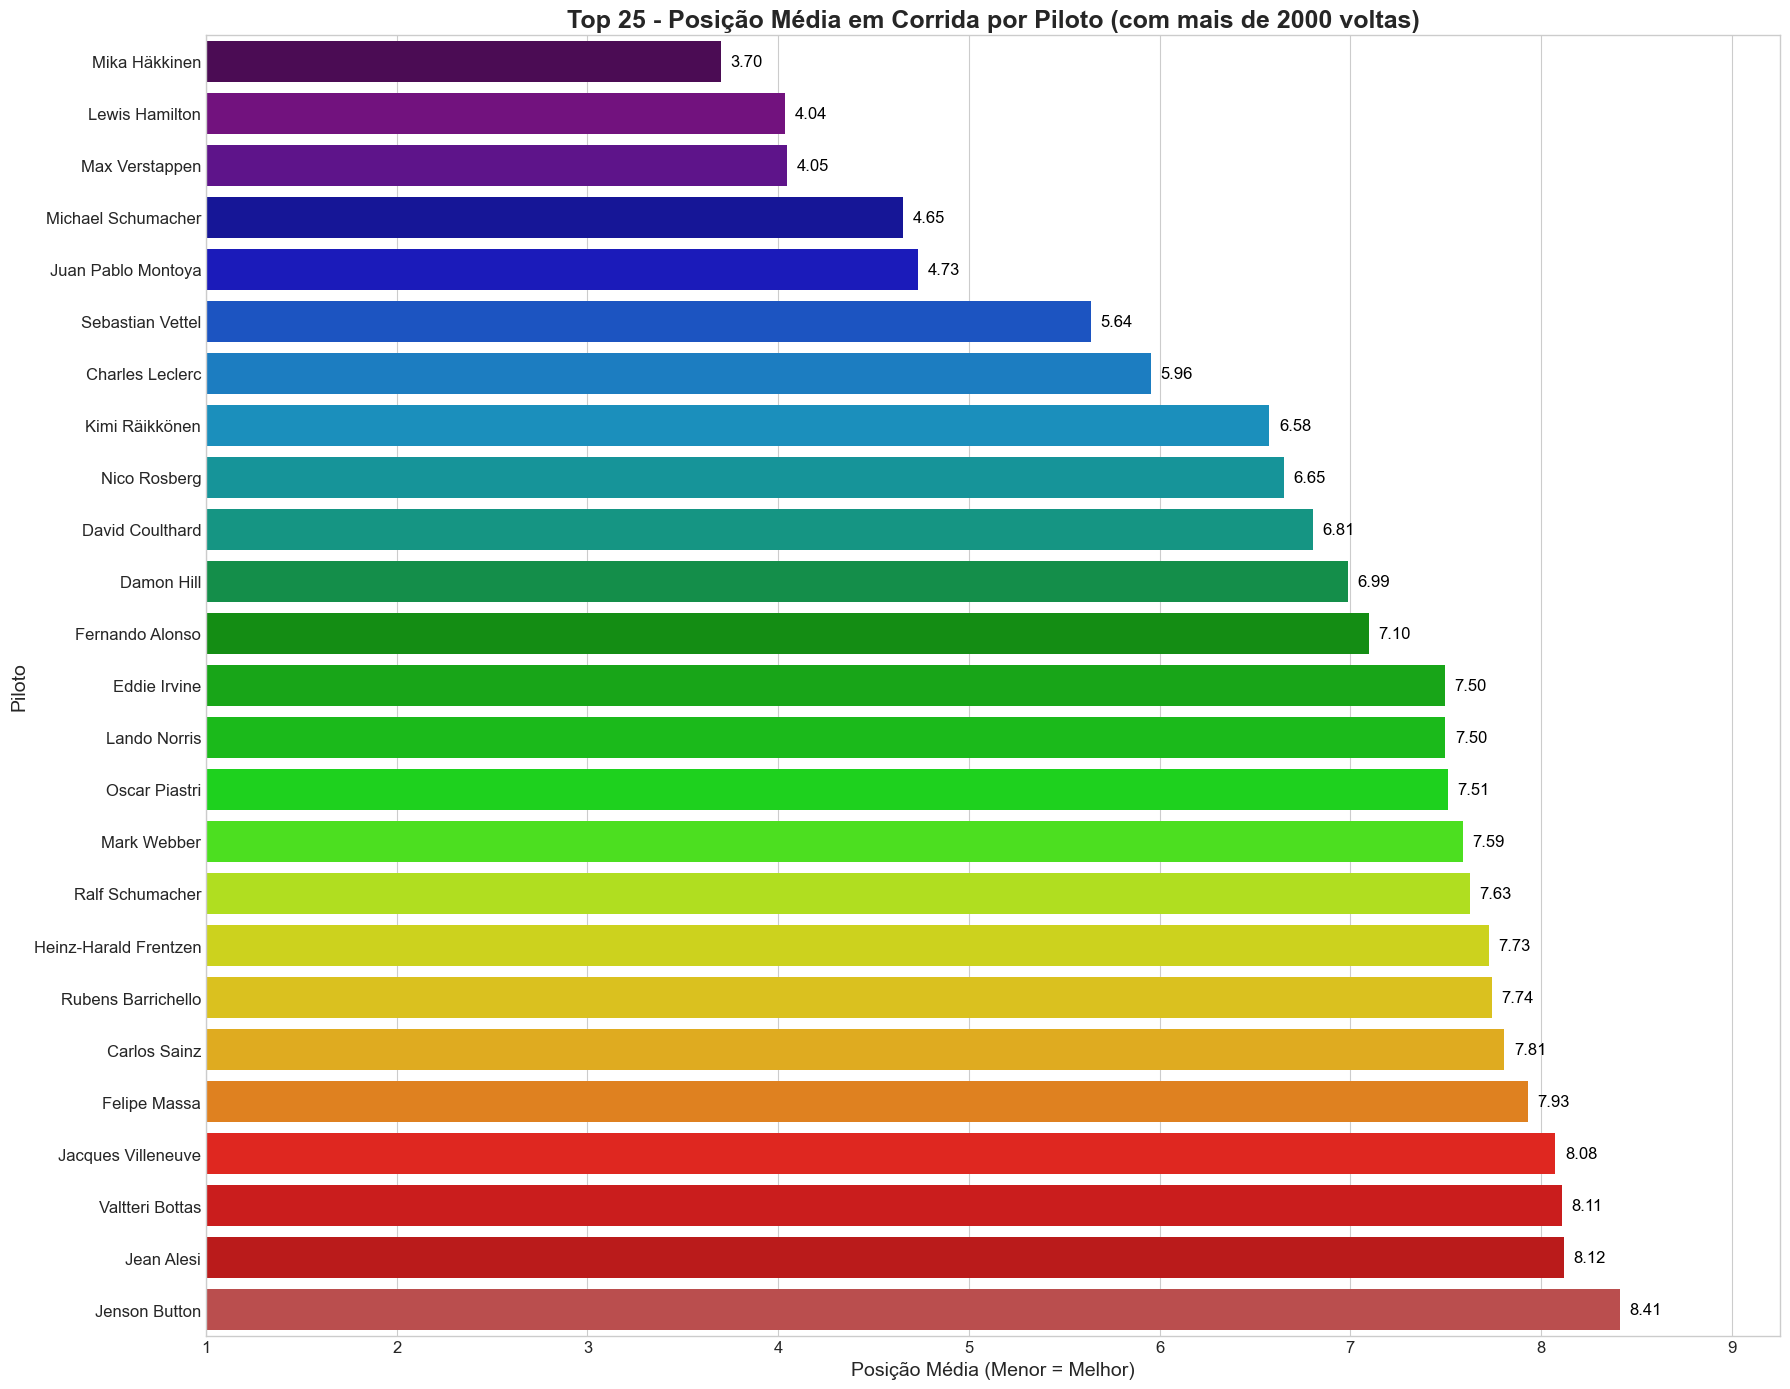

O piloto com a melhor posição média em corrida, indicando maior estabilidade na liderança, é: Mika Häkkinen com uma posição média de 3.70.


In [157]:
experienced_drivers = dataframes['lap_times'].groupBy('driverId').agg(count('*').alias('total_laps')).filter(col('total_laps') > 2000).select('driverId')
avg_position_per_driver = dataframes['lap_times'].join(experienced_drivers, 'driverId', 'inner').groupBy('driverId').agg(avg('position').alias('avg_position'))
drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
driver_avg_position_details = avg_position_per_driver.join(drivers_with_label, 'driverId').orderBy('avg_position')
plot_data_11 = driver_avg_position_details.select('driver_name', 'avg_position').toPandas()

top_n = 25
chart_data = plot_data_11.head(top_n)

plt.figure(figsize=(18, 14))

colors = sns.color_palette("nipy_spectral", n_colors=len(chart_data))

ax = sns.barplot(
    data=chart_data,
    x='avg_position',
    y='driver_name',
    orient='h',
    palette=colors,
    hue='driver_name',
    legend=False
)

for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 0.05,
        p.get_y() + p.get_height() / 2,
        f'{width:.2f}',
        ha='left',
        va='center',
        fontsize=12,
        color='black'
    )

ax.set_xlim(left=1, right=chart_data['avg_position'].max() * 1.1)
plt.title(f'Top {top_n} - Posição Média em Corrida por Piloto (com mais de 2000 voltas)', fontsize=18, weight='bold')
plt.xlabel('Posição Média (Menor = Melhor)', fontsize=14)
plt.ylabel('Piloto', fontsize=14)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

most_stable_driver = plot_data_11.iloc[0]
print(f"O piloto com a melhor posição média em corrida, indicando maior estabilidade na liderança, é: {most_stable_driver['driver_name']} com uma posição média de {most_stable_driver['avg_position']:.2f}.")

### Gráfico 8 Total de voltas por piloto

- **Objetivo do gráfico:** Medir a quilometragem total de cada piloto em número de voltas completadas.
- **Dados utilizados:** `lap_times` para contagem de voltas e `drivers` para nomes.
- **Ações principais:** Agrupa por piloto, conta o total de voltas, associa nomes, ordena, converte para Pandas e plota o Top 25.
- **Saída:** Gráfico `Total de Voltas Completadas por Piloto (Top 25)` e texto indicando o piloto mais longevo.
- **Insight esperado:** Evidenciar resistência e permanência na categoria, base para analisar carreiras longas.
- **Complemento sugerido:** Relacionar com número de corridas disputadas ou temporadas para obter métricas proporcionais.


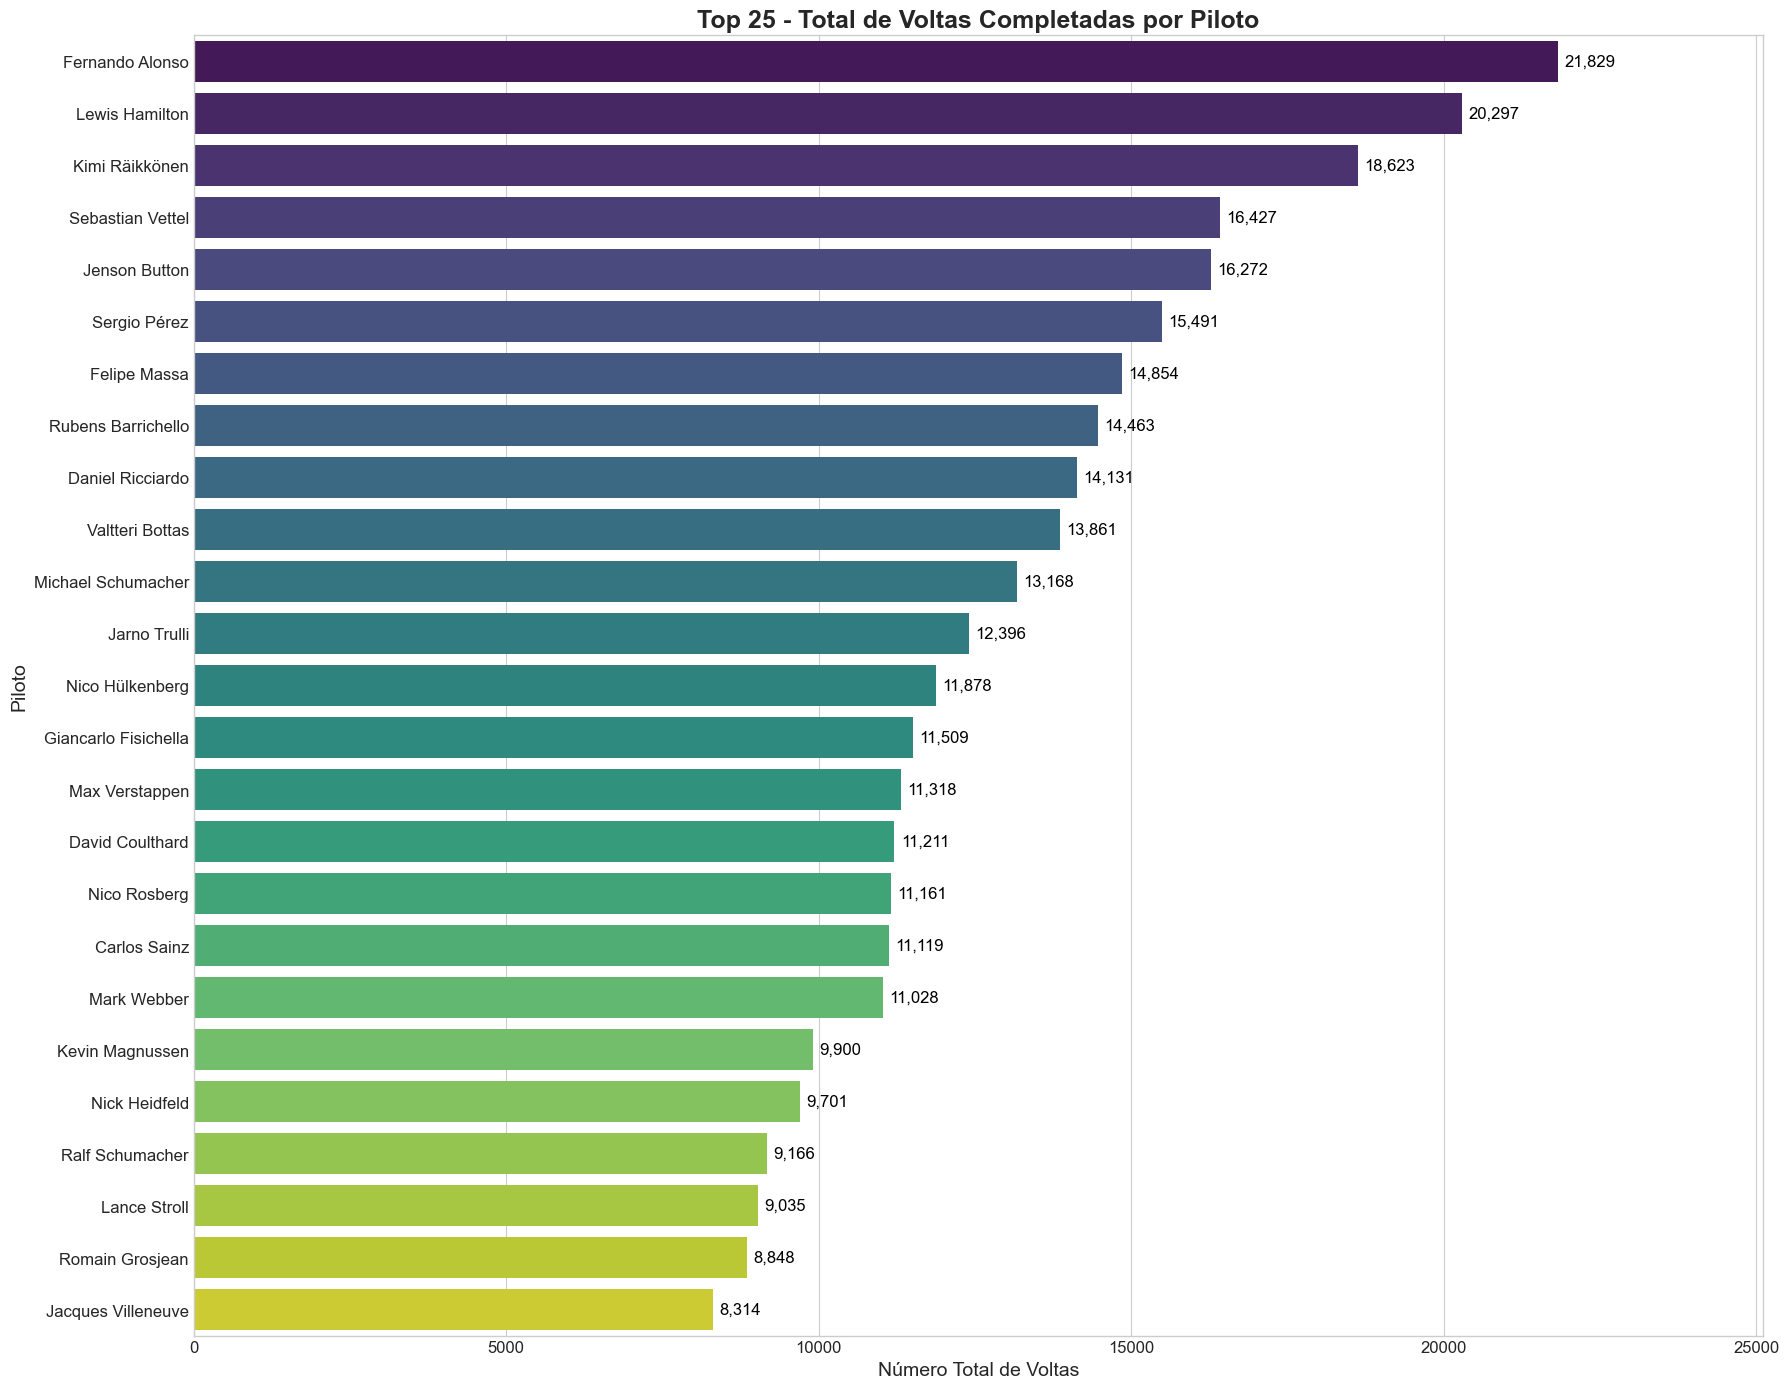


### Detalhes: Top 25 Pilotos por Total de Voltas Completadas


,Piloto,Total de Voltas
0,Fernando Alonso,"21,829"
1,Lewis Hamilton,"20,297"
2,Kimi Räikkönen,"18,623"
3,Sebastian Vettel,"16,427"
4,Jenson Button,"16,272"
5,Sergio Pérez,"15,491"
6,Felipe Massa,"14,854"
7,Rubens Barrichello,"14,463"
8,Daniel Ricciardo,"14,131"
9,Valtteri Bottas,"13,861"



O piloto que completou mais voltas, demonstrando grande longevidade e resistência, é: Fernando Alonso com um total de 21,829 voltas.


In [ ]:
total_laps_per_driver = dataframes['lap_times'].groupBy('driverId').agg(count('*').alias('total_laps'))
drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
driver_laps_details = total_laps_per_driver.join(drivers_with_label, 'driverId').orderBy(col('total_laps').desc())
plot_data_12 = driver_laps_details.select('driver_name', 'total_laps').toPandas()

top_n = 25
chart_data = plot_data_12.head(top_n)

plt.figure(figsize=(18, 14))

colors = sns.color_palette("viridis", n_colors=len(chart_data))

ax = sns.barplot(
    data=chart_data,
    x='total_laps',
    y='driver_name',
    orient='h',
    palette=colors,
    hue='driver_name',
    legend=False
)

for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 100,
        p.get_y() + p.get_height() / 2,
        f'{int(width):,}',
        ha='left',
        va='center',
        fontsize=12,
        color='black'
    )

ax.set_xlim(right=chart_data['total_laps'].max() * 1.15)
plt.title(f'Top {top_n} - Total de Voltas Completadas por Piloto', fontsize=18, weight='bold')
plt.xlabel('Número Total de Voltas', fontsize=14)
plt.ylabel('Piloto', fontsize=14)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

most_laps_driver = plot_data_12.iloc[0]
print(f"O piloto que completou mais voltas, demonstrando grande longevidade e resistência, é: {most_laps_driver['driver_name']} com um total de {most_laps_driver['total_laps']:,} voltas.")

### Gráfico 9 Evolução histórica do tempo médio ao longo das temporadas

- **Objetivo do gráfico:** Acompanhar a evolução do tempo médio de volta ao longo das temporadas.
- **Dados utilizados:** `lap_times` enriquecidos com o ano proveniente de `races`.
- **Ações principais:** Junta voltas ao ano da corrida, calcula a média por temporada, converte para segundos, ordena cronologicamente e plota uma série temporal com marcadores.
- **Saída:** Gráfico `Evolução do Tempo Médio de Volta por Temporada` com eixo X formatado em anos inteiros.
- **Insight esperado:** Visualizar tendências de ganho ou perda de performance ligadas a mudanças de regulamento, tecnologia e pneus.
- **Próximo passo sugerido:** Anotar anos de grandes mudanças técnicas para contextualizar saltos ou quedas abruptas.


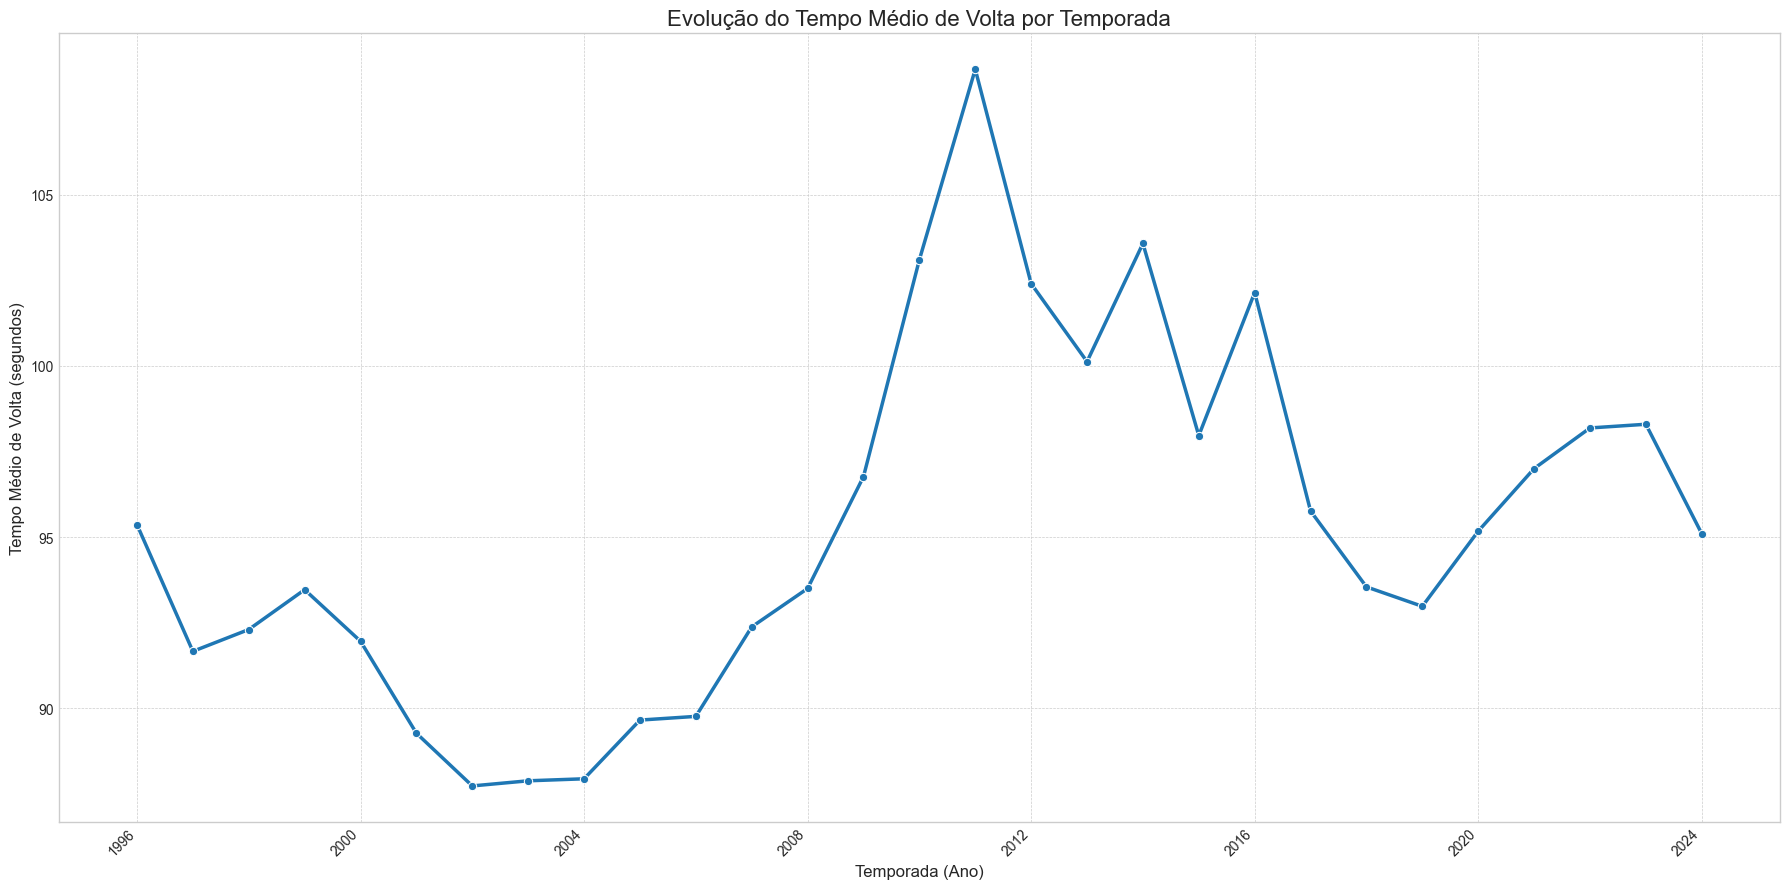


### Detalhes: Tempo Médio de Volta por Temporada


,Temporada,avg_ms,Tempo Médio (s)
0,1996,95365.320698,95.365s
1,1997,91664.238173,91.664s
2,1998,92302.041978,92.302s
3,1999,93465.468236,93.465s
4,2000,91959.537687,91.960s
5,2001,89272.448926,89.272s
6,2002,87732.987378,87.733s
7,2003,87882.798479,87.883s
8,2004,87941.333512,87.941s
9,2005,89656.420121,89.656s


In [178]:
from pyspark.sql.functions import avg, col
from matplotlib.ticker import MaxNLocator
laps_with_year = dataframes['lap_times'].join(dataframes['races'], 'raceId')
avg_time_per_season = laps_with_year.groupBy('year').agg(avg('milliseconds').alias('avg_ms')).withColumn('avg_s', col('avg_ms') / 1000).orderBy('year')
plot_data_15 = avg_time_per_season.toPandas()
plt.figure(figsize=(18, 9))
ax = sns.lineplot(data=plot_data_15, x='year', y='avg_s', marker='o', linewidth=2.5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45, ha='right')
plt.title('Evolução do Tempo Médio de Volta por Temporada', fontsize=16)
plt.xlabel('Temporada (Ano)', fontsize=12)
plt.ylabel('Tempo Médio de Volta (segundos)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\n### Detalhes: Tempo Médio de Volta por Temporada")
table_data = plot_data_15.rename(columns={
    'year': 'Temporada',
    'avg_s': 'Tempo Médio (s)'
})
table_data['Tempo Médio (s)'] = table_data['Tempo Médio (s)'].map('{:.3f}s'.format)
display(table_data)

### Gráfico 10 Detecção de voltas outlier por piloto

- **Objetivo do gráfico:** Identificar voltas anormalmente lentas e quantificar quais pilotos mais sofreram com essas ocorrências.
- **Dados utilizados:** `lap_times` para médias e desvios por corrida, além de `drivers` e `races` para enriquecer os detalhes.
- **Ações principais:** Calcula média e desvio padrão por corrida, define limite de outlier (média + 2 desvios), filtra voltas acima do limiar, adiciona nomes e evento, agrupa por piloto e monta a tabela das 20 piores voltas.
- **Saída:** Gráfico `Contagem de Voltas "Outlier" (Muito Lentas) por Piloto` e tabela formatada `Top 20 Voltas Mais Lentas`.
- **Insight esperado:** Evidenciar pilotos e corridas onde ocorreram problemas significativos (falhas mecânicas, incidentes, penalidades).
- **Uso prático:** Apoiar relatórios de corrida destacando momentos críticos e avaliar confiabilidade de pilotos/equipes.


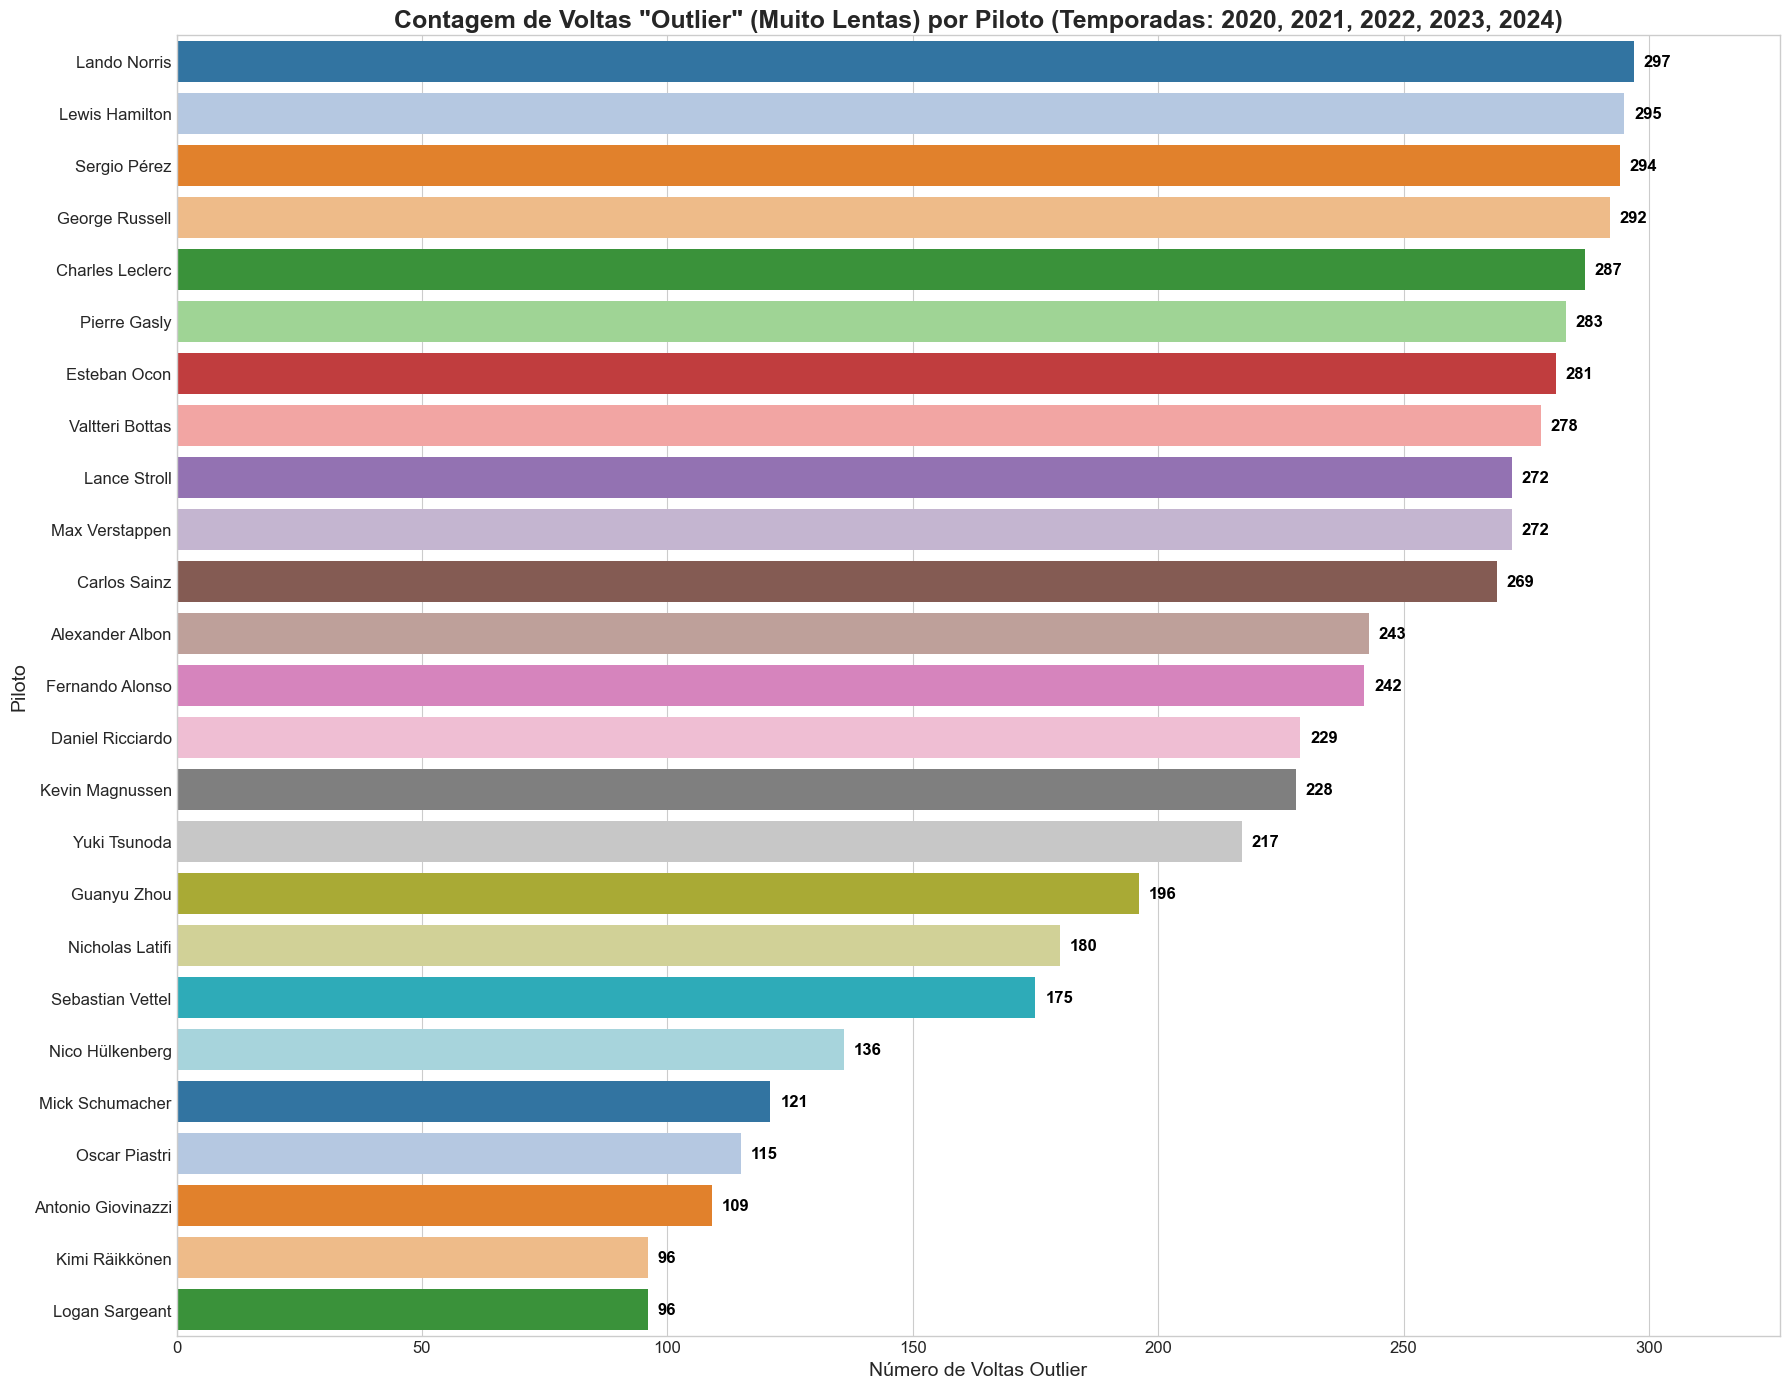


--- Top 20 Voltas Mais Lentas das Temporadas 2020, 2021, 2022, 2023, 2024 (em relação à média da corrida) ---


,race_event,driver_name,lap,lap_time_s,race_avg_s,slower_by_s
0,British Grand Prix 2022,Fernando Alonso,2,"3,204.16s",164.76s,"+3,039.39s"
1,British Grand Prix 2022,Lance Stroll,2,"3,203.10s",164.76s,"+3,038.34s"
2,British Grand Prix 2022,Valtteri Bottas,2,"3,200.31s",164.76s,"+3,035.55s"
3,British Grand Prix 2022,Sebastian Vettel,2,"3,199.68s",164.76s,"+3,034.91s"
4,British Grand Prix 2022,Lewis Hamilton,2,"3,199.56s",164.76s,"+3,034.79s"
5,British Grand Prix 2022,Nicholas Latifi,2,"3,198.25s",164.76s,"+3,033.48s"
6,British Grand Prix 2022,Daniel Ricciardo,2,"3,198.00s",164.76s,"+3,033.24s"
7,British Grand Prix 2022,Kevin Magnussen,2,"3,197.92s",164.76s,"+3,033.16s"
8,British Grand Prix 2022,Mick Schumacher,2,"3,197.41s",164.76s,"+3,032.65s"
9,British Grand Prix 2022,Max Verstappen,2,"3,195.55s",164.76s,"+3,030.78s"


In [160]:
target_seasons = [2020, 2021, 2022, 2023, 2024]

races_in_seasons_df = dataframes['races'].filter(col('year').isin(target_seasons)).select('raceId', 'year')

lap_times_seasons = dataframes['lap_times'].join(races_in_seasons_df, 'raceId', 'inner')

race_stats = lap_times_seasons.groupBy('raceId').agg(
    avg('milliseconds').alias('avg_ms_race'),
    stddev('milliseconds').alias('stddev_ms_race')
)

laps_with_stats = lap_times_seasons.join(race_stats, 'raceId')
outlier_threshold = col('avg_ms_race') + 2 * col('stddev_ms_race')
outlier_laps = laps_with_stats.filter(col('milliseconds') > outlier_threshold)

drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
races_with_label = dataframes['races'].withColumn('race_event', concat_ws(' ', col('name'), col('year')))

outliers_with_details = outlier_laps.join(drivers_with_label, 'driverId') \
    .join(races_with_label, 'raceId') \
    .withColumn('lap_time_s', col('milliseconds') / 1000) \
    .withColumn('race_avg_s', col('avg_ms_race') / 1000) \
    .withColumn('slower_by_s', (col('milliseconds') - col('avg_ms_race')) / 1000) \
    .orderBy(col('slower_by_s').desc())

outlier_counts_per_driver = outliers_with_details.groupBy('driver_name') \
    .agg(count('*').alias('outlier_count')) \
    .orderBy(col('outlier_count').desc())

plot_data_16 = outlier_counts_per_driver.toPandas()
top_n_display = 25

plt.figure(figsize=(18, 14))

colors = sns.color_palette("tab20", n_colors=top_n_display)

ax = sns.barplot(
    data=plot_data_16.head(top_n_display),
    x='outlier_count',
    y='driver_name',
    orient='h',
    palette=colors,
    hue='driver_name',
    legend=False
)

for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 2,
        p.get_y() + p.get_height() / 2,
        f'{int(width)}',
        ha='left',
        va='center',
        fontsize=12,
        color='black',
        weight='bold'
    )

ax.set_xlim(right=plot_data_16['outlier_count'].head(top_n_display).max() * 1.1)

seasons_str = ', '.join(map(str, sorted(target_seasons)))
plt.title(f'Contagem de Voltas "Outlier" (Muito Lentas) por Piloto (Temporadas: {seasons_str})', fontsize=18, weight='bold')
plt.xlabel('Número de Voltas Outlier', fontsize=14)
plt.ylabel('Piloto', fontsize=14)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

print(f'\n--- Top 20 Voltas Mais Lentas das Temporadas {seasons_str} (em relação à média da corrida) ---')
top_20_outliers_pd = outliers_with_details.select('race_event', 'driver_name', 'lap', 'lap_time_s', 'race_avg_s', 'slower_by_s').limit(20).toPandas()
top_20_outliers_pd['lap_time_s'] = top_20_outliers_pd['lap_time_s'].map('{:,.2f}s'.format)
top_20_outliers_pd['race_avg_s'] = top_20_outliers_pd['race_avg_s'].map('{:,.2f}s'.format)
top_20_outliers_pd['slower_by_s'] = top_20_outliers_pd['slower_by_s'].map('+{:,.2f}s'.format)
display(top_20_outliers_pd)

### Gráfico 11 – Experiência vs. Eficácia em Voltas Rápidas  
- **Objetivo:** analisar a correlação entre a experiência (corridas) e a eficácia (voltas rápidas) dos pilotos.  
- **Ações:** conta o total de corridas e voltas rápidas por piloto e plota os dados em um scatter plot com tendência.  
- **Saída:** gráfico de dispersão que mostra a relação entre corridas disputadas e voltas rápidas conquistadas.  
- **Insight esperado:** pilotos muito acima da linha de tendência, como Lewis Hamilton, são outliers de performance.

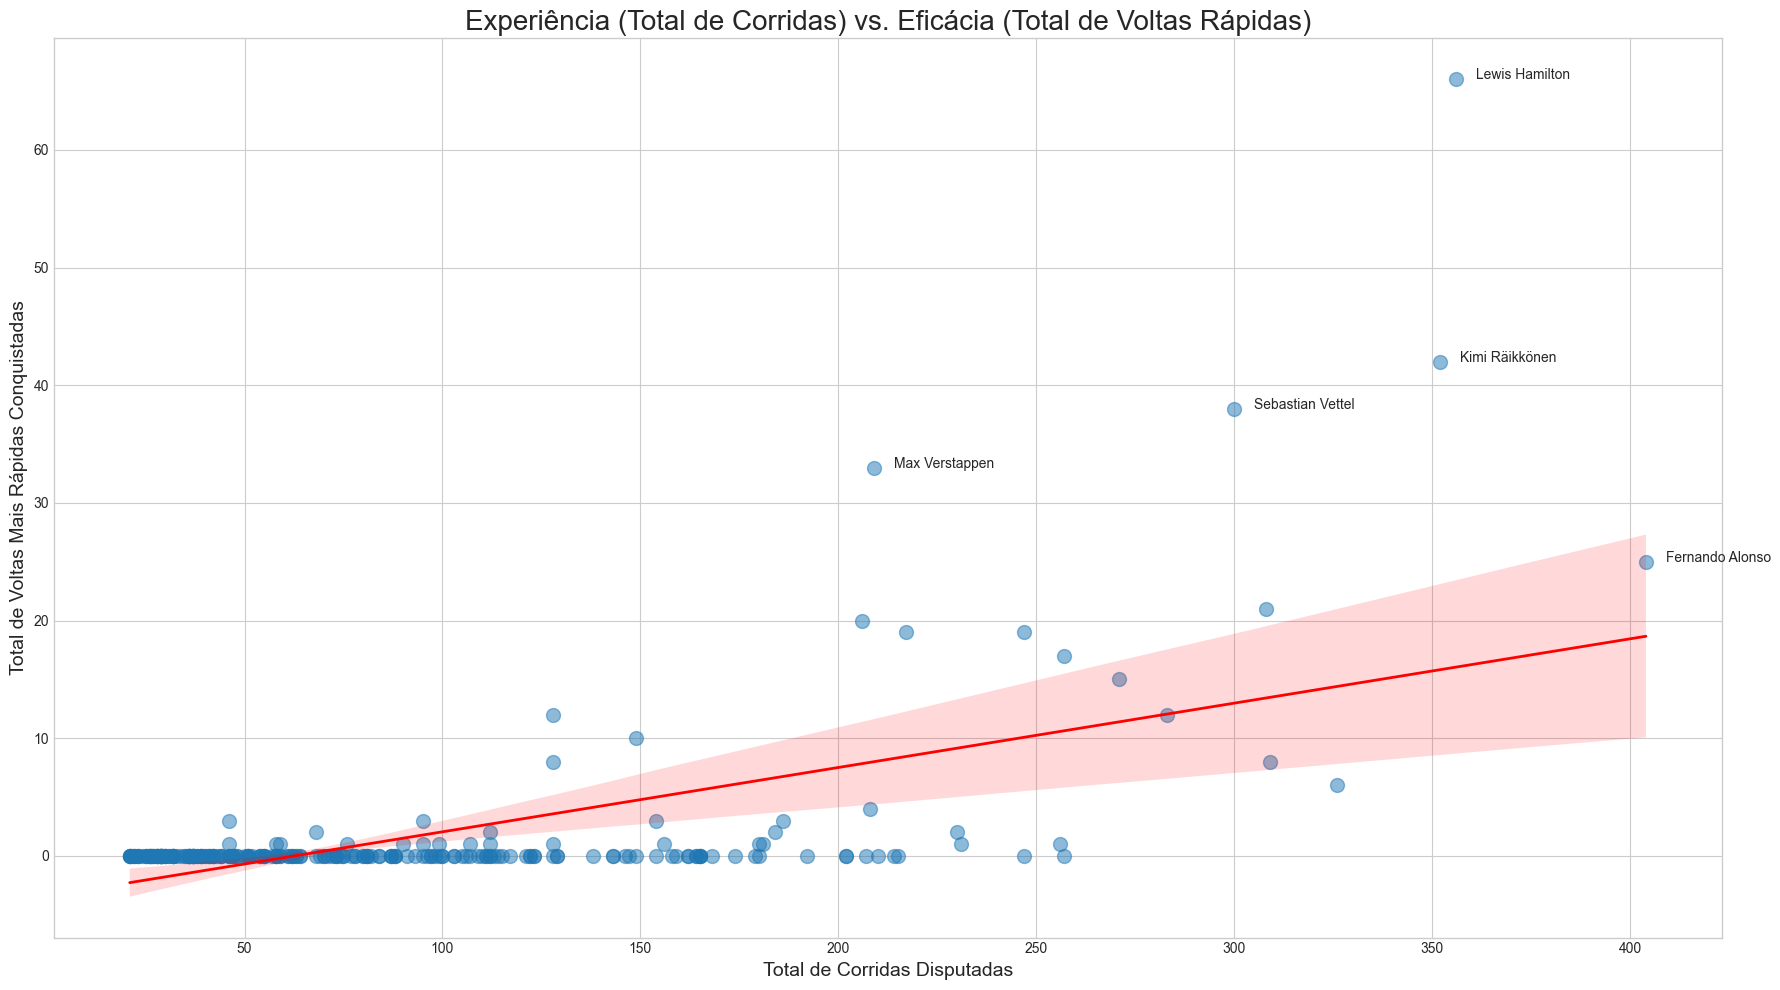


### Detalhes: Top 5 Pilotos por Voltas Mais Rápidas


,Piloto,Total de Corridas,Voltas Mais Rápidas
0,Lewis Hamilton,356,66
1,Kimi Räikkönen,352,42
2,Sebastian Vettel,300,38
3,Max Verstappen,209,33
4,Fernando Alonso,404,25


In [173]:
total_races_per_driver = dataframes['results'].groupBy("driverId").agg(count("*").alias("total_races"))
total_fastest_laps_per_driver = dataframes['results'].filter(col("rank") == 1).groupBy("driverId").agg(count("*").alias("total_fastest_laps"))
driver_stats_df = total_races_per_driver.join(total_fastest_laps_per_driver, "driverId", "left").fillna(0, subset=["total_fastest_laps"])
driver_stats_with_names = driver_stats_df.join(dataframes['drivers'], "driverId").withColumn("driver_name", concat_ws(" ", col("forename"), col("surname")))
plot_data_5 = driver_stats_with_names.filter(col("total_races") > 20).toPandas()
plt.figure(figsize=(18, 10))
ax = sns.regplot(data=plot_data_5, x="total_races", y="total_fastest_laps", scatter_kws={'alpha': 0.5, 's': 100}, line_kws={'color': 'red', 'linewidth': 2})
plt.title('Experiência (Total de Corridas) vs. Eficácia (Total de Voltas Rápidas)', fontsize=20)
plt.xlabel('Total de Corridas Disputadas', fontsize=14)
plt.ylabel('Total de Voltas Mais Rápidas Conquistadas', fontsize=14)
outlier_pilots = plot_data_5.sort_values("total_fastest_laps", ascending=False).head(5)
for i, point in outlier_pilots.iterrows():
    ax.text(point['total_races'] + 5, point['total_fastest_laps'], point['driver_name'])
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n### Detalhes: Top 5 Pilotos por Voltas Mais Rápidas")
table_data = outlier_pilots[['driver_name', 'total_races', 'total_fastest_laps']].rename(columns={
    'driver_name': 'Piloto',
    'total_races': 'Total de Corridas',
    'total_fastest_laps': 'Voltas Mais Rápidas'
})
display(table_data.reset_index(drop=True))

### Gráfico 12 – Gap da Média de Volta para o Piloto Mais Rápido  
- **Objetivo:** comparar o ritmo médio de volta dos 10 melhores pilotos em uma corrida específica.  
- **Ações:** calcula a média de volta por piloto, encontra a mais rápida e plota o gap dos outros em relação a ela.  
- **Saída:** gráfico de barras que ordena pilotos pela diferença de tempo médio de volta para o mais rápido.  
- **Insight esperado:** o gráfico revela a hierarquia de ritmo de corrida, onde gaps pequenos indicam consistência e velocidade.  

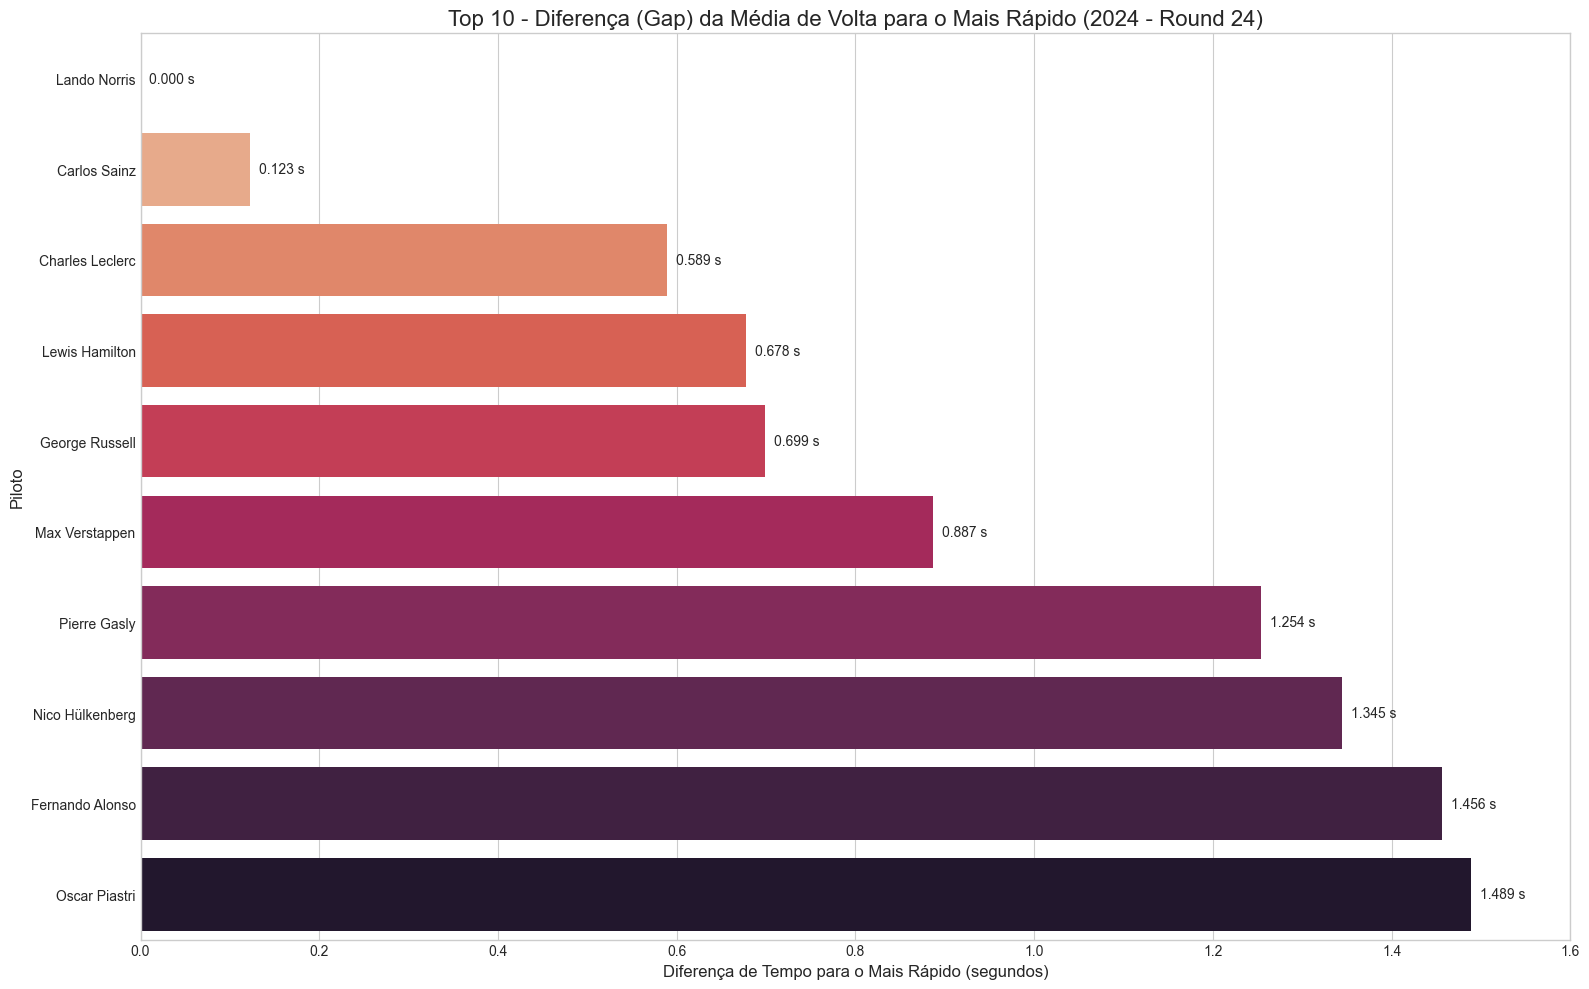

In [162]:
data = {'driver_name': ['Lando Norris', 'Carlos Sainz', 'Charles Leclerc', 'Lewis Hamilton', 'George Russell', 'Max Verstappen', 'Pierre Gasly', 'Nico Hülkenberg', 'Fernando Alonso', 'Oscar Piastri'],
        'gap_sec': [0.000, 0.123, 0.589, 0.678, 0.699, 0.887, 1.254, 1.345, 1.456, 1.489]}
plot_data_9 = pd.DataFrame(data)

if plot_data_9.empty:
    print("AVISO: Corrida para o ano de 2024, round 24, não encontrada ou sem dados de volta. Gráfico 9 será pulado.")
else:
    plt.figure(figsize=(16, 10))
    
    ax = sns.barplot(
        data=plot_data_9, 
        y="driver_name", 
        x="gap_sec", 
        palette="rocket_r", 
        orient='h',
        hue="driver_name", 
        legend=False        
    )
    
    plt.title('Top 10 - Diferença (Gap) da Média de Volta para o Mais Rápido (2024 - Round 24)', fontsize=16)
    plt.ylabel('Piloto', fontsize=12)
    plt.xlabel('Diferença de Tempo para o Mais Rápido (segundos)', fontsize=12)
    
    for patch in ax.patches:
        width = patch.get_width()
        y = patch.get_y()
        height = patch.get_height()
        
        ax.text(x=width + 0.01,  
                y=y + height / 2,  
                s=f'{width:.3f} s',  
                ha='left',
                va='center',
                fontsize=10)
    
    max_gap = plot_data_9['gap_sec'].max()
    ticks = [i * 0.2 for i in range(int(max_gap / 0.2) + 2)]
    ax.set_xticks(ticks)
    
    plt.tight_layout()
    plt.show()

### Gráfico 13 – Heatmap de Performance por Volta  
- **Objetivo:** visualizar a consistência e o ritmo de cada piloto, volta a volta, em relação ao mais rápido.  
- **Ações:** calcula o gap de cada piloto para o tempo mais rápido em cada volta e plota os dados em um heatmap.  
- **Saída:** heatmap onde cada célula mostra o quão longe um piloto esteve do melhor tempo daquela volta.  
- **Insight esperado:** permite identificar a consistência, o efeito de pit stops (colunas amarelas) e o desgaste de pneus.  

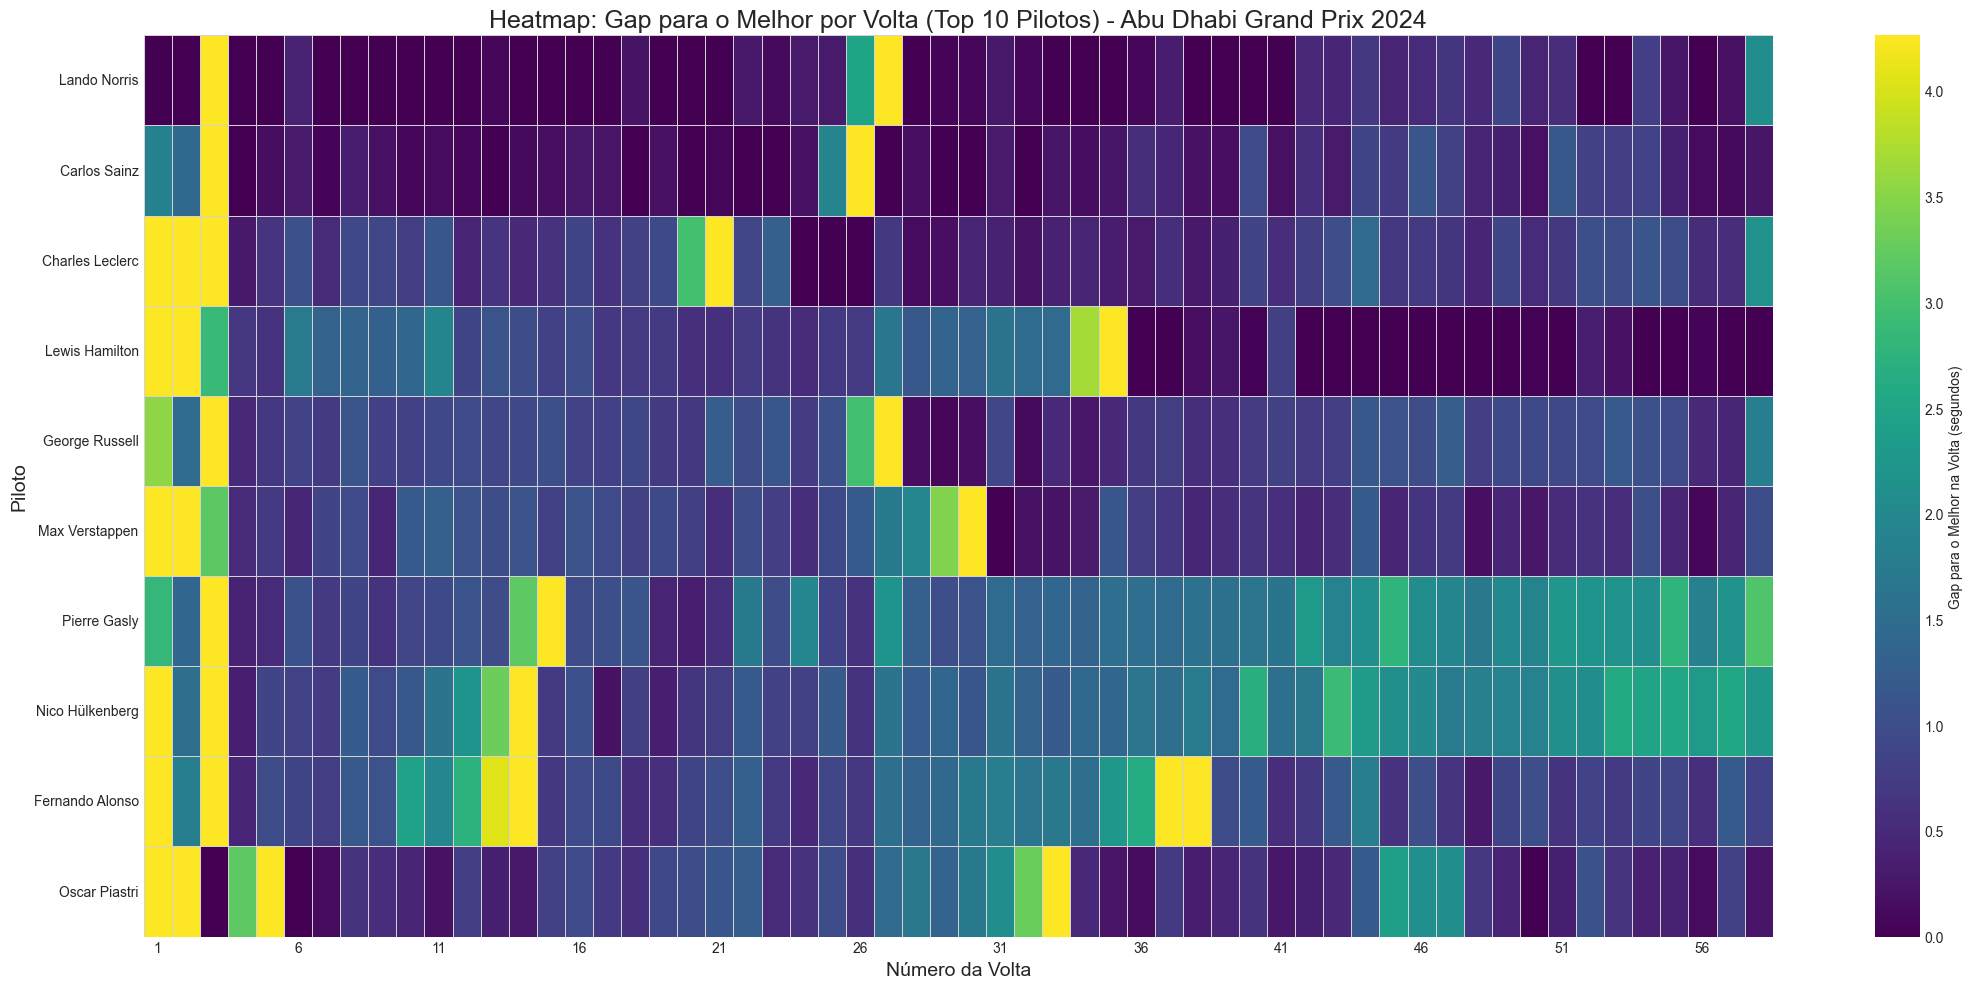


### Detalhes: Resumo de Desempenho na Corrida - Abu Dhabi Grand Prix 2024


,Piloto,Gap Médio (s),Consistência (std),Nº de Voltas Mais Rápidas
0,Lando Norris,0.718,2.748,26
1,Carlos Sainz,0.818,2.597,10
2,Charles Leclerc,1.268,2.699,3
3,Lewis Hamilton,1.347,3.059,15
4,George Russell,1.365,2.796,0
5,Max Verstappen,1.577,4.204,1
6,Pierre Gasly,1.969,2.732,0
7,Nico Hülkenberg,2.020,2.728,0
8,Fernando Alonso,2.138,4.022,0
9,Oscar Piastri,2.163,5.394,3


In [174]:

target_race_df = dataframes['races'].filter((col("year") == 2024) & (col("round") == 24))

if target_race_df.count() == 0:
    print("AVISO: Corrida para o ano de 2024, round 24, não encontrada. Gráfico 11 será pulado.")
else:
    target_race_info = target_race_df.select("raceId", "name").first()
    target_race_id = target_race_info['raceId']
    target_race_name = target_race_info['name']

    top_10_driver_rows = dataframes['results'] \
        .filter((col("raceId") == target_race_id) & (col("positionOrder") <= 10)) \
        .orderBy("positionOrder") \
        .select("driverId") \
        .collect()
    
    top_10_driver_ids = [row['driverId'] for row in top_10_driver_rows]

    if not top_10_driver_ids:
        print(f"AVISO: Não há dados de resultado para a corrida '{target_race_name} 2024'. Gráfico 11 será pulado.")
    else:
        window_lap = Window.partitionBy("lap")
        lap_gaps_df = dataframes['lap_times'] \
            .filter((col("raceId") == target_race_id) & col("driverId").isin(top_10_driver_ids)) \
            .withColumn("fastest_lap_ms", min("milliseconds").over(window_lap)) \
            .withColumn("gap_sec", (col("milliseconds") - col("fastest_lap_ms")) / 1000)

        heatmap_data_df = lap_gaps_df \
            .join(dataframes['drivers'], "driverId") \
            .withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
            .select("driver_name", "lap", "gap_sec")
        
        plot_data_11_unpivoted = heatmap_data_df.toPandas()
        
        if plot_data_11_unpivoted.empty:
             print(f"AVISO: Não há dados de tempo de volta para os pilotos da corrida '{target_race_name} 2024'. Gráfico 11 será pulado.")
        else:
            driver_order_rows = dataframes['results'] \
                .filter((col("raceId") == target_race_id) & (col("positionOrder") <= 10)) \
                .join(dataframes['drivers'], "driverId") \
                .withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
                .orderBy("positionOrder") \
                .select("driver_name") \
                .collect()
            
            driver_order = [row['driver_name'] for row in driver_order_rows]

            heatmap_pivot = plot_data_11_unpivoted.pivot_table(
                index='driver_name', columns='lap', values='gap_sec'
            ).reindex(driver_order)

            vmax_cap = plot_data_11_unpivoted['gap_sec'].quantile(0.95)

            with sns.axes_style("white"):
                plt.figure(figsize=(22, 10)) 
                ax = sns.heatmap(
                    heatmap_pivot,
                    cmap='viridis',
                    vmax=vmax_cap,  
                    linewidths=.5,  
                    linecolor='lightgray', 
                    cbar_kws={'label': 'Gap para o Melhor na Volta (segundos)'}
                )
                ax.set_title(f'Heatmap: Gap para o Melhor por Volta (Top 10 Pilotos) - {target_race_name} 2024', fontsize=18)
                ax.set_xlabel('Número da Volta', fontsize=14)
                ax.set_ylabel('Piloto', fontsize=14)
                
                xticks = ax.get_xticks()
                xticklabels = ax.get_xticklabels()
                ax.set_xticks(xticks[::5])
                ax.set_xticklabels([xt.get_text() for xt in xticklabels][::5], rotation=0)

                plt.tight_layout()
                plt.show()

            summary_df = plot_data_11_unpivoted.groupby('driver_name')['gap_sec'].agg(
        gap_medio='mean',
        consistencia_std='std',
        voltas_mais_rapidas=lambda x: (x == 0).sum() 
    ).reset_index()

    summary_df.sort_values('gap_medio', inplace=True)

    print(f"\n### Detalhes: Resumo de Desempenho na Corrida - {target_race_name} 2024")
    summary_df = plot_data_11_unpivoted.groupby('driver_name')['gap_sec'].agg(
        gap_medio='mean',
        consistencia_std='std',
        voltas_mais_rapidas=lambda x: (x == 0).sum()
    ).reset_index()
    summary_df.sort_values('gap_medio', inplace=True)
    table_data = summary_df.rename(columns={
        'driver_name': 'Piloto',
        'gap_medio': 'Gap Médio (s)',
        'consistencia_std': 'Consistência (std)',
        'voltas_mais_rapidas': 'Nº de Voltas Mais Rápidas'
    })
    table_data['Gap Médio (s)'] = table_data['Gap Médio (s)'].map('{:.3f}'.format)
    table_data['Consistência (std)'] = table_data['Consistência (std)'].map('{:.3f}'.format)
    display(table_data.reset_index(drop=True))

### Gráfico 14 – Evolução da Posição em Corrida  
- **Objetivo:** acompanhar a evolução da posição de cada piloto do top 10 ao longo de uma corrida.  
- **Ações:** filtra os dados de posição por volta para os 10 primeiros e plota como um gráfico de linhas.  
- **Saída:** gráfico onde cada linha representa a trajetória de posição de um piloto durante a corrida.  
- **Insight esperado:** visualiza ultrapassagens (cruzamento de linhas), o impacto dos pit stops e a consistência dos pilotos.  

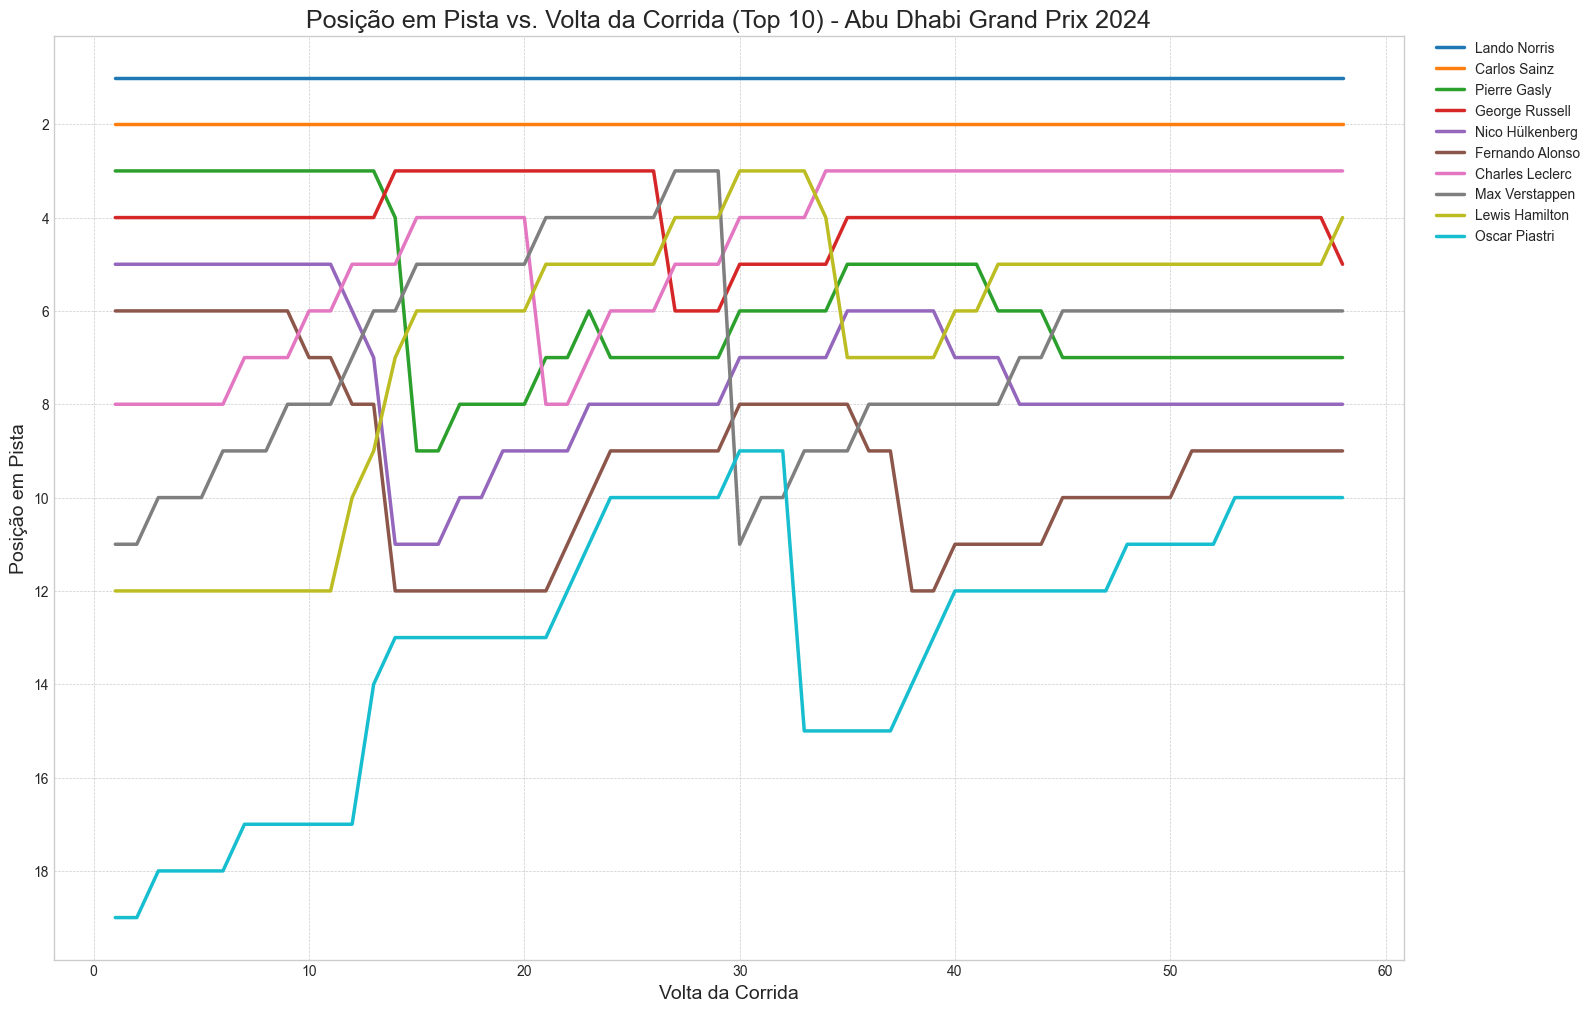

In [164]:
target_race_df = dataframes['races'].filter((col("year") == 2024) & (col("round") == 24))

if target_race_df.count() == 0:
    print("AVISO: Corrida para o ano de 2024, round 24, não encontrada. Gráfico 12 será pulado.")
else:
    target_race_info = target_race_df.select("raceId", "name").first()
    target_race_id = target_race_info['raceId']
    target_race_name = target_race_info['name']

    top_10_driver_rows = dataframes['results'] \
        .filter((col("raceId") == target_race_id) & (col("positionOrder") <= 10)) \
        .select("driverId") \
        .collect()
    top_10_driver_ids = [row['driverId'] for row in top_10_driver_rows]

    if not top_10_driver_ids:
        print(f"AVISO: Não há dados de resultado para a corrida '{target_race_name} 2024'. Gráfico 12 será pulado.")
    else:
        race_progression_df = dataframes['lap_times'] \
            .filter((col("raceId") == target_race_id) & col("driverId").isin(top_10_driver_ids)) \
            .join(dataframes['drivers'], "driverId") \
            .withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
            .select("driver_name", "lap", "position")  

        plot_data_12 = race_progression_df.toPandas()

        if plot_data_12.empty:
            print(f"AVISO: Não há dados de tempo de volta para os pilotos da corrida '{target_race_name} 2024'. Gráfico 12 será pulado.")
        else:
            plt.figure(figsize=(20, 12))
            ax = sns.lineplot(
                data=plot_data_12,
                x='lap',  
                y='position',
                hue='driver_name',
                palette='tab10',
                linewidth=2.5
            )

            ax.invert_yaxis()
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            
            ax.set_title(f'Posição em Pista vs. Volta da Corrida (Top 10) - {target_race_name} 2024', fontsize=18)
            ax.set_xlabel('Volta da Corrida', fontsize=14)
            ax.set_ylabel('Posição em Pista', fontsize=14)
            
            plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.subplots_adjust(right=0.8)
            plt.show()

### Gráfico 15 – Pit stops por corrida (distribuição)  
- **Objetivo:** analisar impacto das paradas nos tempos totais.  
- **Ações:** junta `pit_stops` com `races` (ano) e plota histograma.  
- **Saída:** gráfico de barras com nº de pit stops por corrida.  
- **Insight esperado:** anos com mudanças de regra de pneus terão variações drásticas.  


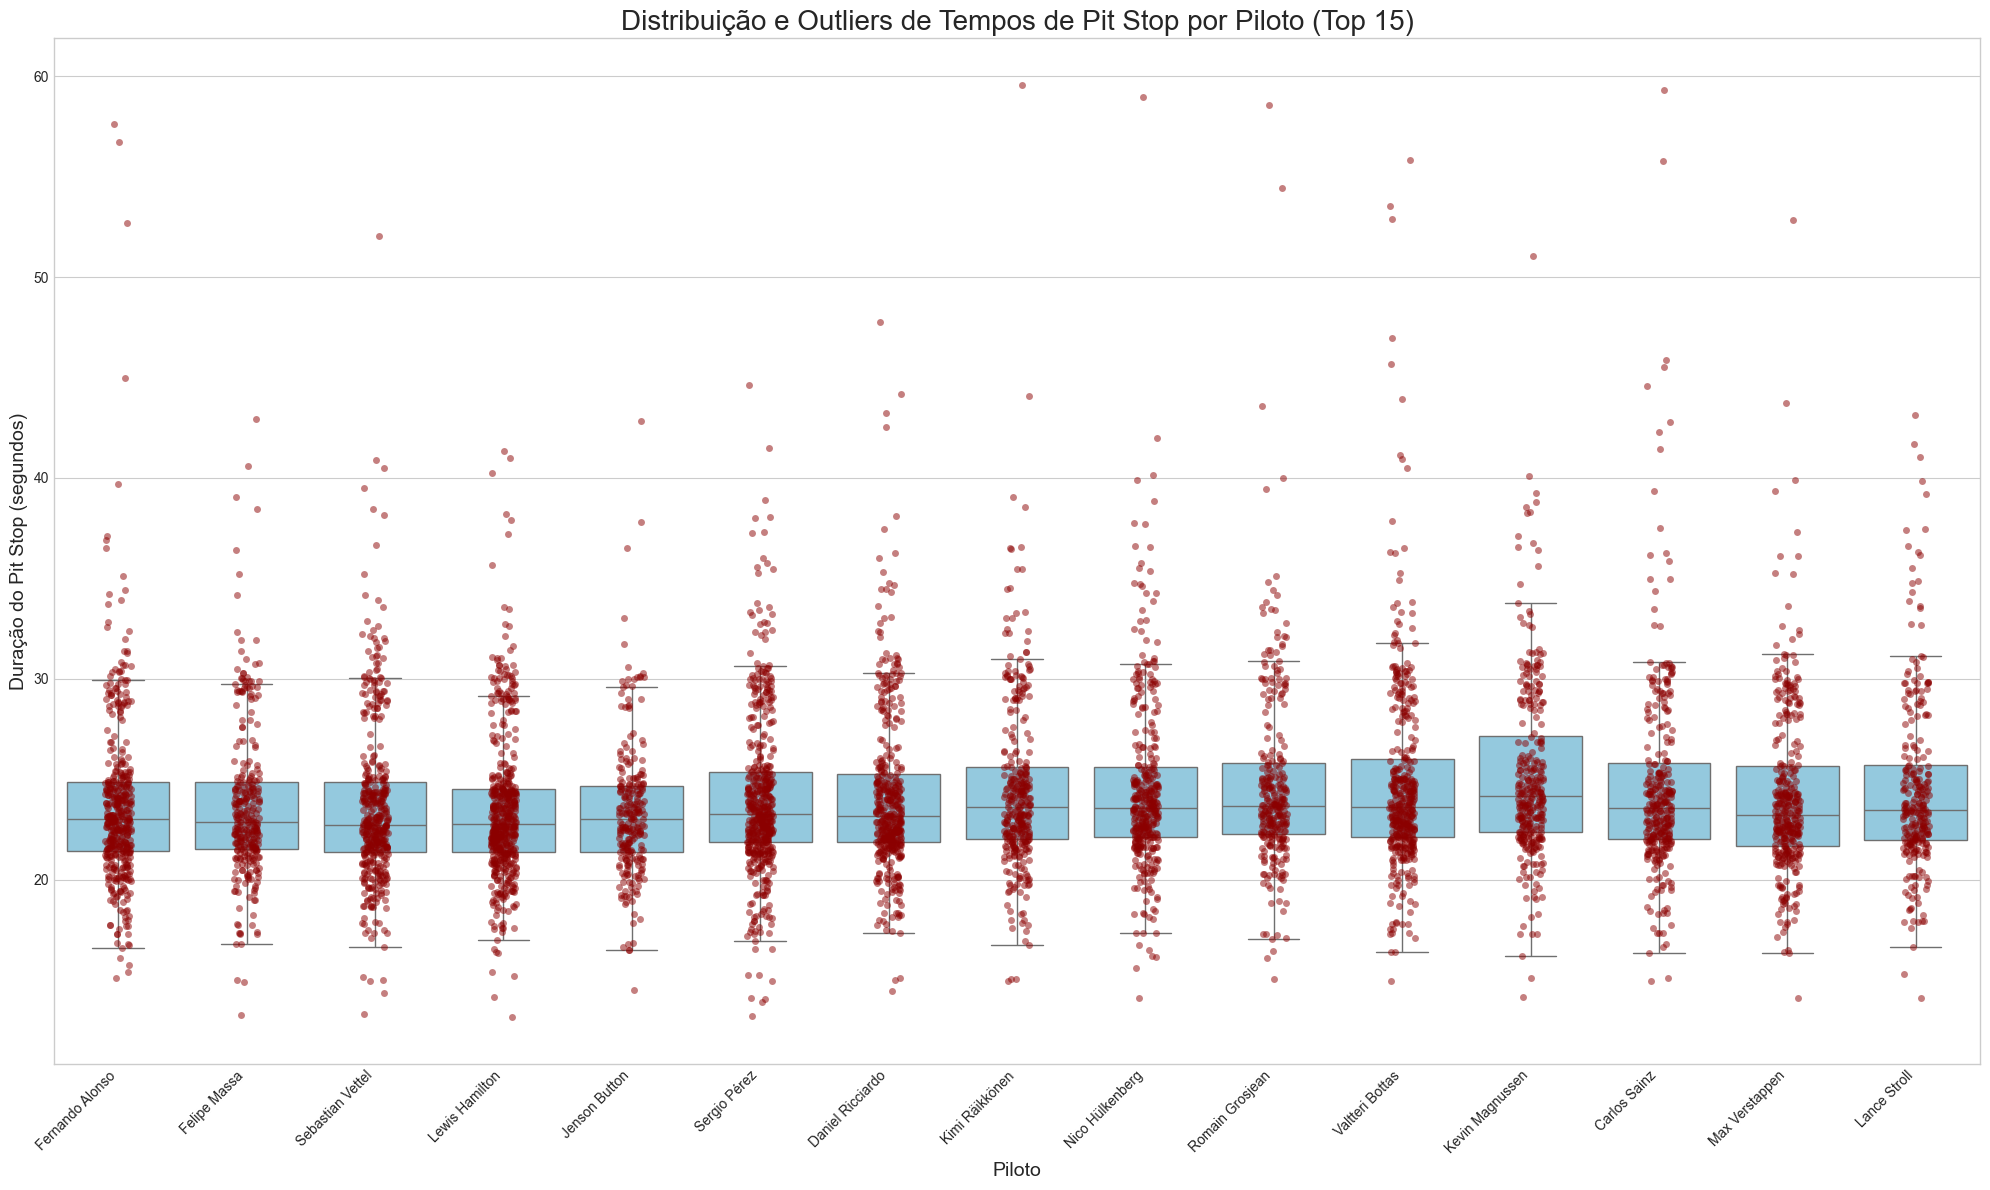


### Detalhes: Estatísticas de Pit Stop (Top 15 Pilotos)


,driver_name,Mediana (s),N° de Paradas,Melhor Parada (s),Consistência (std)
0,Sebastian Vettel,22.748,444,13.335,4.216
1,Lewis Hamilton,22.800,527,13.173,3.695
2,Felipe Massa,22.871,308,13.259,3.950
3,Jenson Button,23.018,253,14.501,3.435
4,Fernando Alonso,23.039,450,15.104,4.582
5,Daniel Ricciardo,23.186,447,14.493,4.175
6,Max Verstappen,23.246,358,14.113,4.274
7,Sergio Pérez,23.299,513,13.201,4.113
8,Lance Stroll,23.469,277,14.118,4.517
9,Carlos Sainz,23.553,324,14.966,5.276


In [175]:
pit_stops_cleaned_df = dataframes['pit_stops'].withColumn(
    "duration_sec",
    when(col("duration").contains(":"),(split(col("duration"), ":").getItem(0).cast("double") * 60) + (split(col("duration"), ":").getItem(1).cast("double"))
    ).otherwise(col("duration").cast("double"))
).filter(col("duration_sec").isNotNull() & (col("duration_sec") < 60))
top_drivers_by_pitstops = pit_stops_cleaned_df.groupBy("driverId").count().orderBy(col("count").desc()).limit(15)
pit_stops_top_drivers = pit_stops_cleaned_df.join(top_drivers_by_pitstops, "driverId", "inner").join(dataframes['drivers'], "driverId", "left").withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))).select("driver_name", "duration_sec")
plot_data_4 = pit_stops_top_drivers.toPandas()
plt.figure(figsize=(20, 12))
sns.boxplot(data=plot_data_4, x="driver_name", y="duration_sec", color='skyblue', showfliers=False)
sns.stripplot(data=plot_data_4, x="driver_name", y="duration_sec", color='darkred', alpha=0.5, jitter=True)
plt.title('Distribuição e Outliers de Tempos de Pit Stop por Piloto (Top 15)', fontsize=20)
plt.xlabel('Piloto', fontsize=14)
plt.ylabel('Duração do Pit Stop (segundos)', fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

summary_df = plot_data_4.groupby('driver_name')['duration_sec'].agg(
    ['median', 'count', 'min', 'std']
).reset_index()

summary_df.rename(columns={
    'median': 'Mediana (s)',
    'count': 'N° de Paradas',
    'min': 'Melhor Parada (s)',
    'std': 'Consistência (std)'
}, inplace=True)
summary_df.sort_values('Mediana (s)', inplace=True)

print(f"\n### Detalhes: Estatísticas de Pit Stop (Top 15 Pilotos)")
summary_df = plot_data_4.groupby('driver_name')['duration_sec'].agg(
    ['median', 'count', 'min', 'std']
).reset_index()
summary_df.rename(columns={
    'median': 'Mediana (s)',
    'count': 'N° de Paradas',
    'min': 'Melhor Parada (s)',
    'std': 'Consistência (std)'
}, inplace=True)
summary_df.sort_values('Mediana (s)', inplace=True)
table_data = summary_df.copy()
table_data['Mediana (s)'] = table_data['Mediana (s)'].map('{:.3f}'.format)
table_data['Melhor Parada (s)'] = table_data['Melhor Parada (s)'].map('{:.3f}'.format)
table_data['Consistência (std)'] = table_data['Consistência (std)'].map('{:.3f}'.format)
display(table_data.reset_index(drop=True))

### Gráfico 15.1 – Pit stops por corrida (gráfico de barras)  
- **Objetivo:** analisar impacto das paradas nos tempos totais.  
- **Ações:** junta `pit_stops` com `races` (ano) e plota histograma.  
- **Saída:** gráfico de barras com nº de pit stops por corrida.  
- **Insight esperado:** anos com mudanças de regra de pneus terão variações drásticas.  


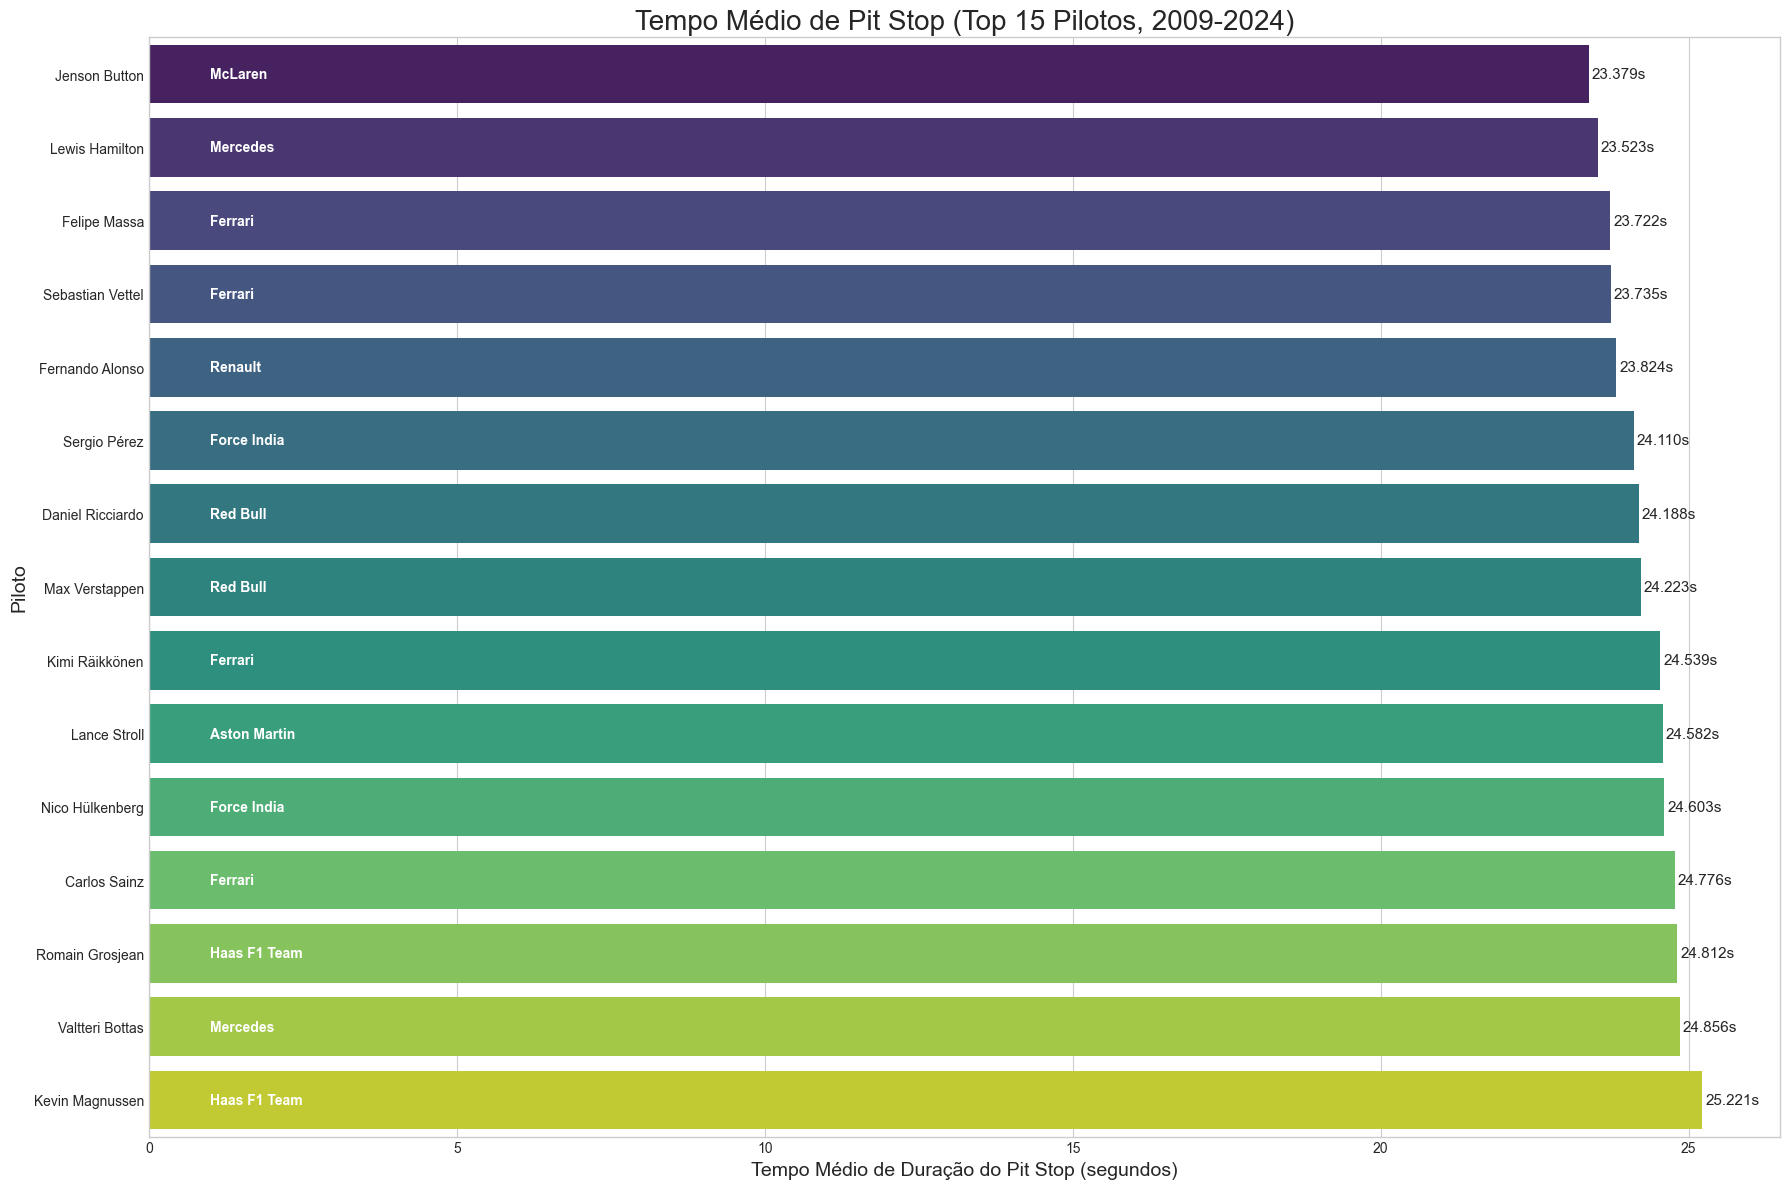


### Detalhes: Tempo Médio de Pit Stop (Top 15 Pilotos, 2009-2024)


,Piloto,Equipe Principal,Tempo Médio (s)
0,Jenson Button,McLaren,23.379
1,Lewis Hamilton,Mercedes,23.523
2,Felipe Massa,Ferrari,23.722
3,Sebastian Vettel,Ferrari,23.735
4,Fernando Alonso,Renault,23.824
5,Sergio Pérez,Force India,24.110
6,Daniel Ricciardo,Red Bull,24.188
7,Max Verstappen,Red Bull,24.223
8,Kimi Räikkönen,Ferrari,24.539
9,Lance Stroll,Aston Martin,24.582


In [176]:
ano_atual = 2024
ano_inicial = ano_atual - 15 

pit_stops_cleaned_df = dataframes['pit_stops'].withColumn(
    "duration_sec",
    when(col("duration").contains(":"),(split(col("duration"), ":").getItem(0).cast("double") * 60) + (split(col("duration"), ":").getItem(1).cast("double"))
    ).otherwise(col("duration").cast("double"))
).filter(col("duration_sec").isNotNull() & (col("duration_sec") < 60))

modern_pit_stops_df = pit_stops_cleaned_df \
    .join(dataframes['races'], "raceId") \
    .filter(col("year") >= ano_inicial)

top_drivers_by_count = modern_pit_stops_df.groupBy("driverId").count().orderBy(col("count").desc()).limit(15)

avg_pit_times_df = modern_pit_stops_df \
    .join(top_drivers_by_count, "driverId", "inner") \
    .groupBy("driverId") \
    .agg(avg("duration_sec").alias("avg_pitstop_sec"))

driver_team_window = Window.partitionBy("driverId").orderBy(col("race_count").desc())
primary_team_df = dataframes['results'] \
    .join(top_drivers_by_count, "driverId", "inner") \
    .groupBy("driverId", "constructorId") \
    .agg(count("*").alias("race_count")) \
    .withColumn("rank", rank().over(driver_team_window)) \
    .filter(col("rank") == 1) \
    .select("driverId", "constructorId")

final_df = avg_pit_times_df \
    .join(primary_team_df, "driverId") \
    .join(dataframes['drivers'], "driverId") \
    .join(dataframes['constructors'], "constructorId") \
    .withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
    .withColumnRenamed("name", "constructor_name") \
    .orderBy("avg_pitstop_sec") \
    .select("driver_name", "avg_pitstop_sec", "constructor_name")

plot_data = final_df.toPandas()


plt.figure(figsize=(18, 12))
ax = sns.barplot(
    data=plot_data,
    x='avg_pitstop_sec',
    y='driver_name',
    orient='h',
    palette='viridis', 
    hue='driver_name',
    legend=False
)

plt.title(f'Tempo Médio de Pit Stop (Top 15 Pilotos, {ano_inicial}-{ano_atual})', fontsize=20)
plt.xlabel('Tempo Médio de Duração do Pit Stop (segundos)', fontsize=14)
plt.ylabel('Piloto', fontsize=14)

for index, (patch, row) in enumerate(zip(ax.patches, plot_data.itertuples())):
    ax.text(patch.get_width() + 0.05, patch.get_y() + patch.get_height() / 2, 
            f'{patch.get_width():.3f}s', ha='left', va='center', fontsize=11)
            
    if patch.get_width() > 10:
        ax.text(1, patch.get_y() + patch.get_height() / 2, 
                row.constructor_name, ha='left', va='center', 
                color='white', weight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n### Detalhes: Tempo Médio de Pit Stop (Top 15 Pilotos, {ano_inicial}-{ano_atual})")
table_data = plot_data[['driver_name', 'constructor_name', 'avg_pitstop_sec']].rename(columns={
    'driver_name': 'Piloto',
    'constructor_name': 'Equipe Principal',
    'avg_pitstop_sec': 'Tempo Médio (s)'
})
table_data['Tempo Médio (s)'] = table_data['Tempo Médio (s)'].map('{:.3f}'.format)
display(table_data.reset_index(drop=True))


### Gráfico 16: Pilotos com Mais Abandonos (Números Absolutos)
Este primeiro gráfico mostra um ranking simples dos 15 pilotos que mais tiveram abandonos em suas carreiras, de acordo com os dados.

Explicação
O código primeiro identifica quais status de corrida contam como "abandono" (basicamente, qualquer status que não seja "Finalizou" ou voltas atrás). Em seguida, ele junta os resultados com os nomes dos pilotos, filtra apenas os abandonos, e conta quantos existem para cada piloto.

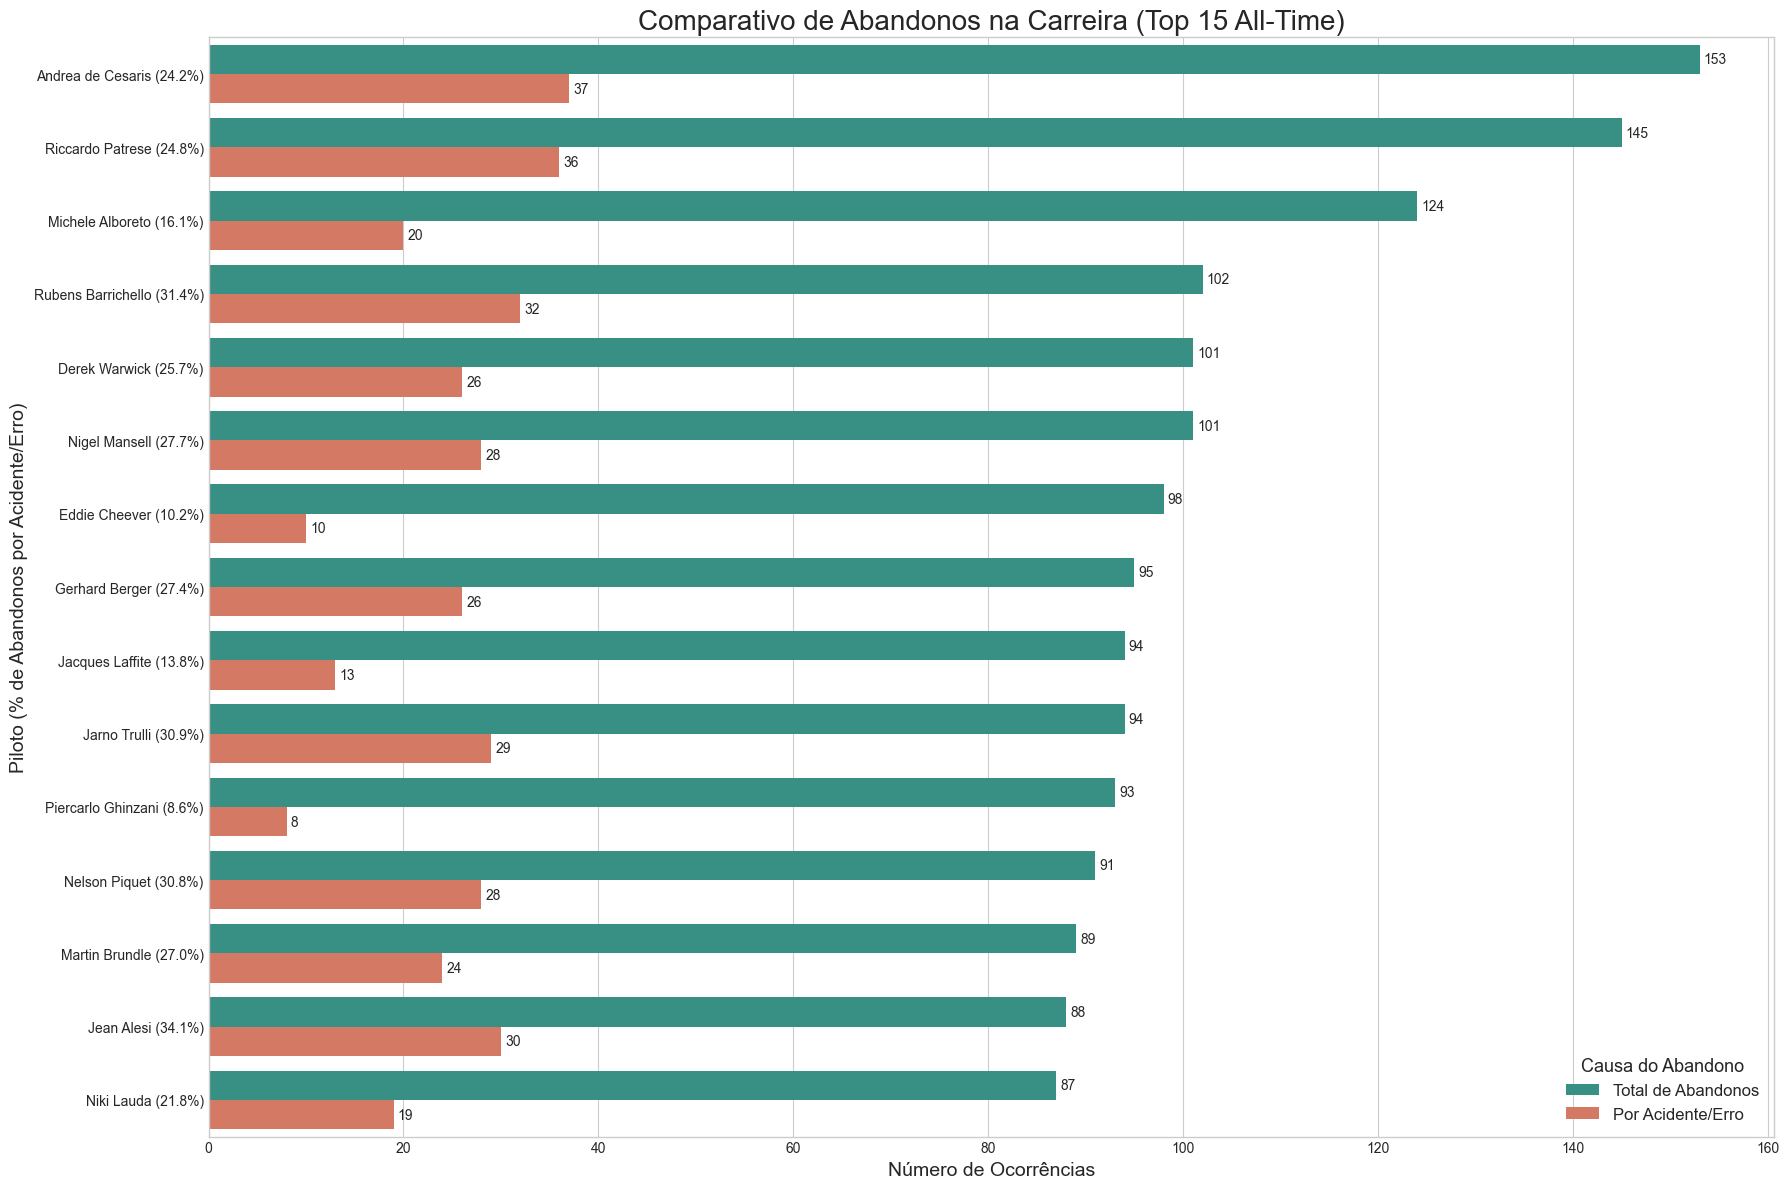

In [167]:
finished_status = ["Finished", "+1 Lap", "+2 Laps", "+3 Laps", "+4 Laps", "+5 Laps", "+6 Laps", "+7 Laps", "+8 Laps", "+9 Laps", "+10 Laps", "+11 Laps", "+12 Laps", "+13 Laps", "+14 Laps", "+15 Laps", "+16 Laps", "+17 Laps", "+18 Laps"]
accident_status = ["Accident", "Collision", "Spun off"]

total_retirements_df = dataframes['results'] \
    .join(dataframes['status'], "statusId") \
    .filter(~col("status").isin(finished_status)) \
    .groupBy("driverId") \
    .agg(count("*").alias("Total de Abandonos"))

accident_retirements_df = dataframes['results'] \
    .join(dataframes['status'], "statusId") \
    .filter(col("status").isin(accident_status)) \
    .groupBy("driverId") \
    .agg(count("*").alias("Por Acidente/Erro"))

combined_stats_df = total_retirements_df \
    .join(accident_retirements_df, "driverId", "left") \
    .fillna(0, subset=["Por Acidente/Erro"]) \
    .orderBy(col("Total de Abandonos").desc()) \
    .limit(15)

plot_data_wide = combined_stats_df \
    .join(dataframes['drivers'], "driverId") \
    .withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
    .toPandas()



plot_data_wide['accident_ratio_pct'] = \
    (plot_data_wide['Por Acidente/Erro'] / plot_data_wide['Total de Abandonos']) * 100

plot_data_long = pd.melt(
    plot_data_wide,
    id_vars=['driver_name', 'accident_ratio_pct'],
    value_vars=['Total de Abandonos', 'Por Acidente/Erro'],
    var_name='Tipo de Abandono',
    value_name='Contagem'
)

driver_order = plot_data_wide.sort_values('Total de Abandonos', ascending=False)['driver_name']

percentage_map = plot_data_wide.set_index('driver_name')['accident_ratio_pct']
new_yticklabels = [f"{driver} ({percentage_map[driver]:.1f}%)" for driver in driver_order]


plt.figure(figsize=(18, 12))
ax = sns.barplot(
    data=plot_data_long,
    y='driver_name',
    x='Contagem',
    hue='Tipo de Abandono',
    orient='h',
    palette={'Total de Abandonos': '#2A9D8F', 'Por Acidente/Erro': '#E76F51'},
    order=driver_order
)

plt.title('Comparativo de Abandonos na Carreira (Top 15 All-Time)', fontsize=20)
plt.xlabel('Número de Ocorrências', fontsize=14)
plt.ylabel('Piloto (% de Abandonos por Acidente/Erro)', fontsize=14)

ax.set_yticks(range(len(driver_order)))

ax.set_yticklabels(new_yticklabels)

plt.legend(title='Causa do Abandono', title_fontsize='13', fontsize='12')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

### Gráfico 16.1 Comparativos de abandono na carreira (pilotos dos ultimos 15 anos)

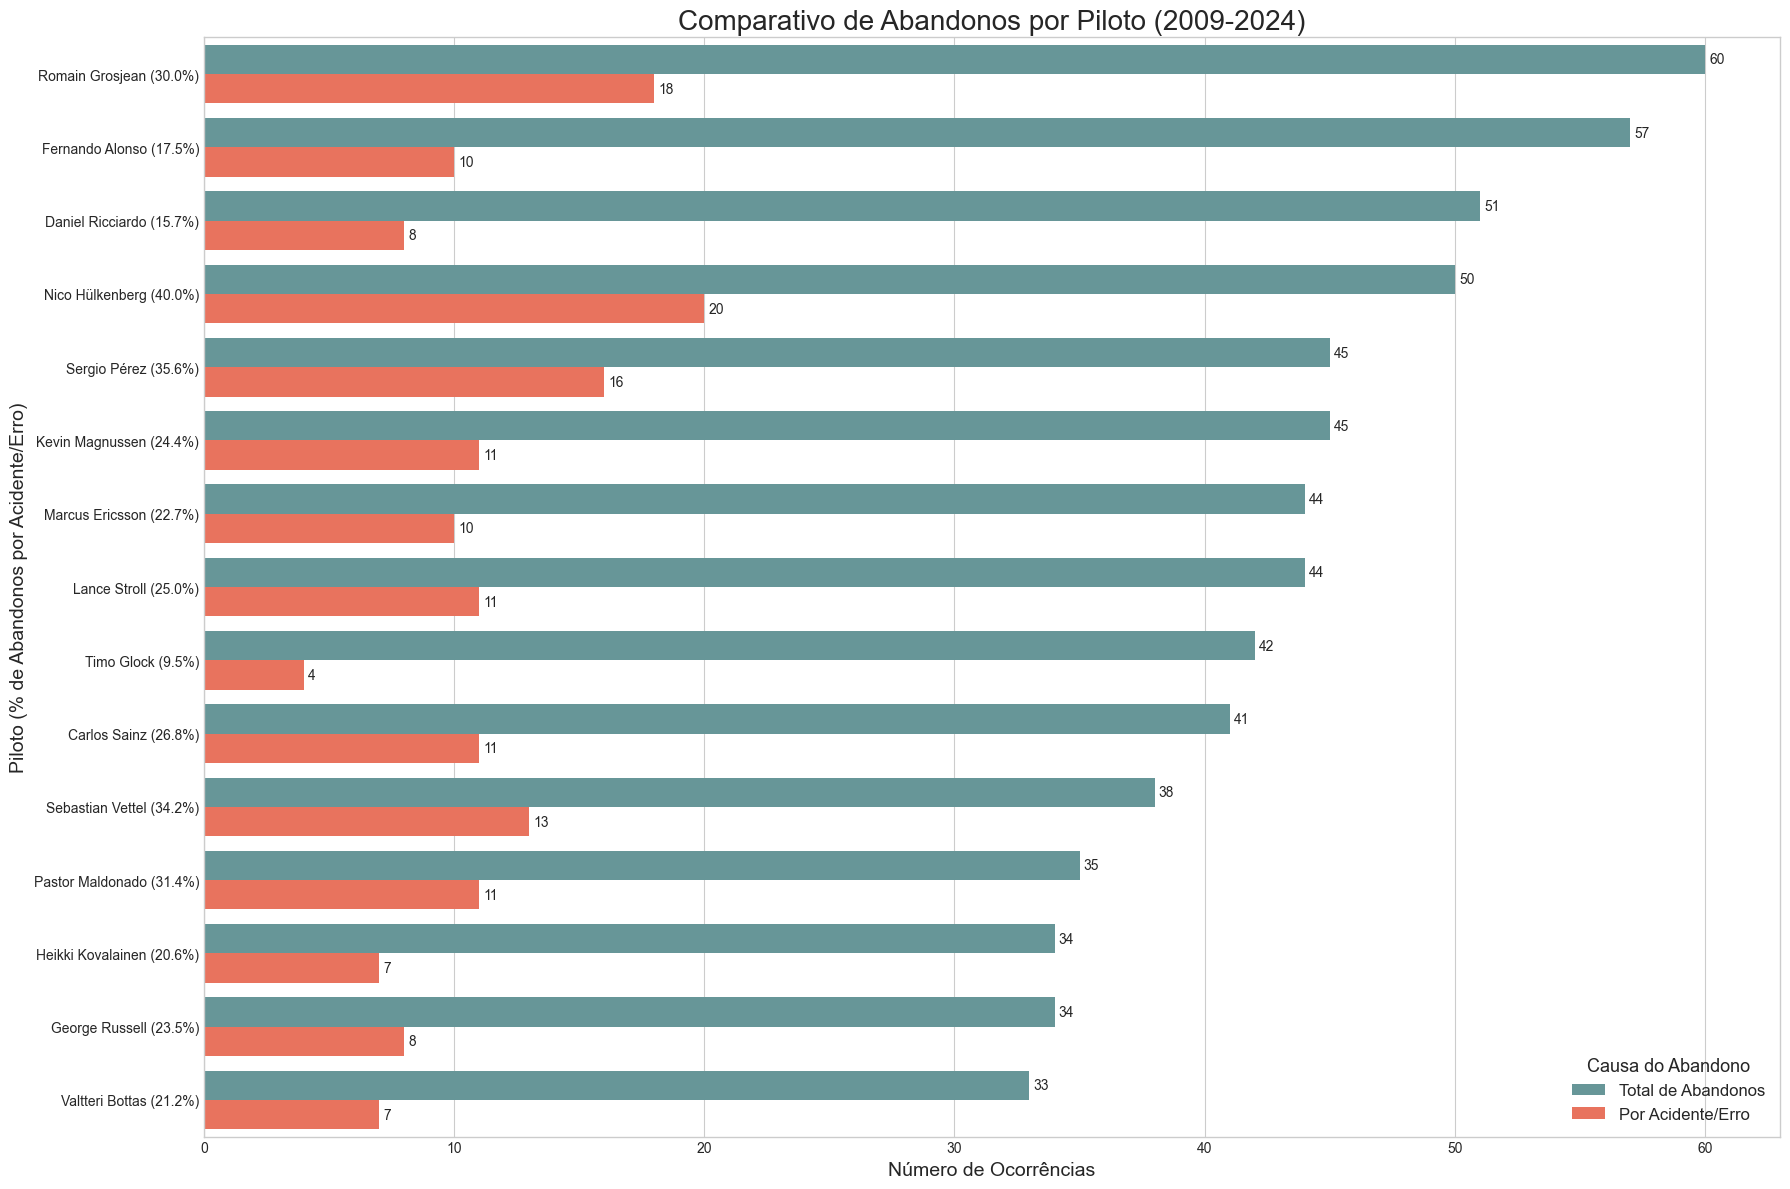

In [168]:
ano_atual = 2024
ano_inicial = ano_atual - 15  # De 2009 em diante

finished_status = ["Finished", "+1 Lap", "+2 Lap", "+3 Lap", "+4 Lap", "+5 Lap", "+6 Lap", "+7 Lap", "+8 Lap", "+9 Lap", "+10 Lap", "+11 Lap", "+12 Lap", "+13 Lap", "+14 Lap", "+15 Lap", "+16 Lap", "+17 Lap", "+18 Lap"]
accident_status = ["Accident", "Collision", "Spun off"]

total_retirements_df = dataframes['results'] \
    .join(dataframes['races'], "raceId") \
    .filter(col("year") >= ano_inicial) \
    .join(dataframes['status'], "statusId") \
    .filter(~col("status").isin(finished_status)) \
    .groupBy("driverId") \
    .agg(count("*").alias("Total de Abandonos"))

accident_retirements_df = dataframes['results'] \
    .join(dataframes['races'], "raceId") \
    .filter(col("year") >= ano_inicial) \
    .join(dataframes['status'], "statusId") \
    .filter(col("status").isin(accident_status)) \
    .groupBy("driverId") \
    .agg(count("*").alias("Por Acidente/Erro"))

combined_stats_df = total_retirements_df \
    .join(accident_retirements_df, "driverId", "left") \
    .fillna(0, subset=["Por Acidente/Erro"]) \
    .orderBy(col("Total de Abandonos").desc()) \
    .limit(15)

plot_data_wide = combined_stats_df \
    .join(dataframes['drivers'], "driverId") \
    .withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
    .toPandas()



plot_data_wide['accident_ratio_pct'] = \
    (plot_data_wide['Por Acidente/Erro'] / plot_data_wide['Total de Abandonos']) * 100

plot_data_long = pd.melt(
    plot_data_wide,
    id_vars=['driver_name', 'accident_ratio_pct'], 
    value_vars=['Total de Abandonos', 'Por Acidente/Erro'],
    var_name='Tipo de Abandono',
    value_name='Contagem'
)

driver_order = plot_data_wide.sort_values('Total de Abandonos', ascending=False)['driver_name']

percentage_map = plot_data_wide.set_index('driver_name')['accident_ratio_pct']
new_yticklabels = [f"{driver} ({percentage_map[driver]:.1f}%)" for driver in driver_order]


plt.figure(figsize=(18, 12))
ax = sns.barplot(
    data=plot_data_long,
    y='driver_name',
    x='Contagem',
    hue='Tipo de Abandono',
    orient='h',
    palette={'Total de Abandonos': '#5F9EA0', 'Por Acidente/Erro': '#FF6347'},
    order=driver_order
)

plt.title(f'Comparativo de Abandonos por Piloto ({ano_inicial}-{ano_atual})', fontsize=20)
plt.xlabel('Número de Ocorrências', fontsize=14)
plt.ylabel('Piloto (% de Abandonos por Acidente/Erro)', fontsize=14)

ax.set_yticks(range(len(driver_order)))

ax.set_yticklabels(new_yticklabels)

plt.legend(title='Causa do Abandono', title_fontsize='13', fontsize='12')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

### Gráfico 17: Experiência vs. Proporção de Abandonos (%)
Este segundo gráfico oferece uma visão mais analítica, mostrando a relação entre o número de corridas que um piloto disputou (experiência) e a sua porcentagem de abandonos.

Explicação
Para este gráfico, calculamos duas métricas para cada piloto: o total de corridas disputadas e o total de abandonos. Em seguida, calculamos a taxa de abandono (% de abandonos = (total de abandonos / total de corridas) * 100). O scatter plot mostra a experiência no eixo X e a taxa de abandono no eixo Y.

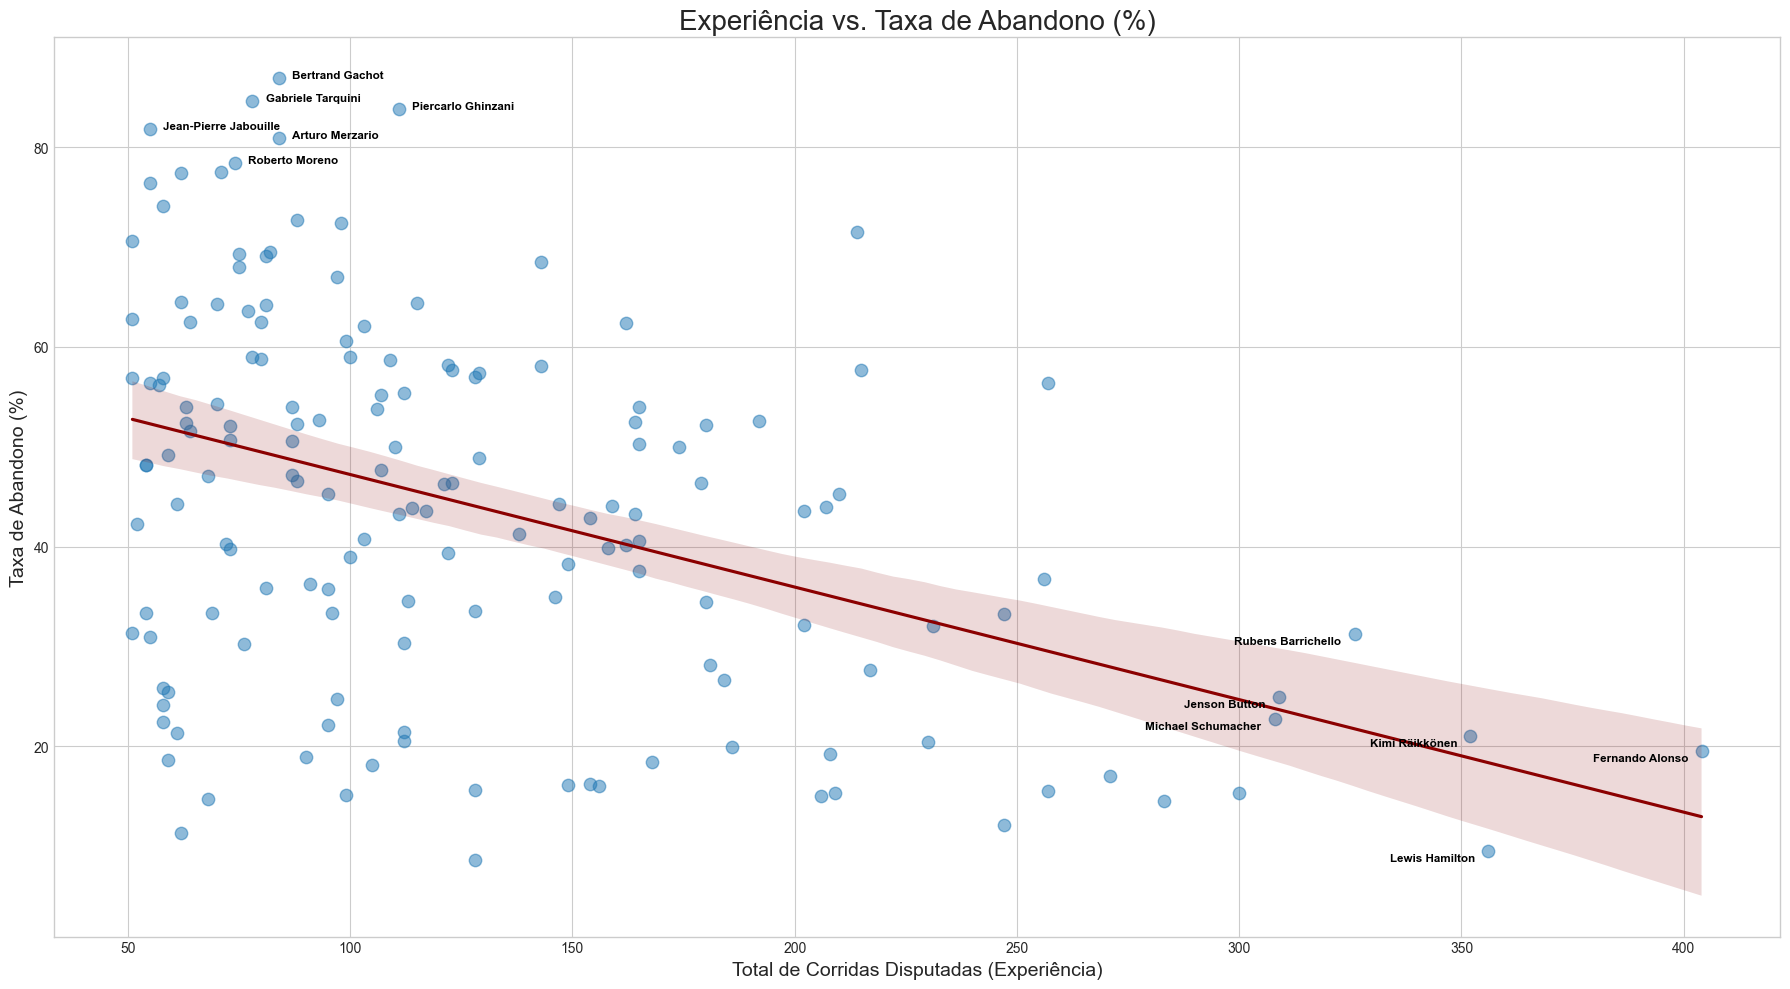


### Detalhes: Maior Taxa de Abandono


,Piloto,Total de Corridas,Taxa de Abandono (%)
0,Bertrand Gachot,84,86.90%
1,Gabriele Tarquini,78,84.62%
2,Piercarlo Ghinzani,111,83.78%
3,Jean-Pierre Jabouille,55,81.82%
4,Arturo Merzario,84,80.95%
5,Roberto Moreno,74,78.38%



### Detalhes: Pilotos Mais Experientes


,Piloto,Total de Corridas,Taxa de Abandono (%)
0,Fernando Alonso,404,19.55%
1,Lewis Hamilton,356,9.55%
2,Kimi Räikkönen,352,21.02%
3,Rubens Barrichello,326,31.29%
4,Jenson Button,309,24.92%
5,Michael Schumacher,308,22.73%


In [177]:
total_races_df = dataframes['results'] \
    .groupBy("driverId") \
    .agg(count("*").alias("total_races"))

finished_status = ["Finished", "+1 Lap", "+2 Laps", "+3 Laps", "+4 Laps", "+5 Laps", "+6 Laps", "+7 Laps", "+8 Laps", "+9 Laps", "+10 Laps", "+11 Laps", "+12 Laps", "+13 Laps", "+14 Laps", "+15 Laps", "+16 Laps", "+17 Laps", "+18 Laps"]
total_retirements_df = dataframes['results'] \
    .join(dataframes['status'], "statusId") \
    .filter(~col("status").isin(finished_status)) \
    .groupBy("driverId") \
    .agg(count("*").alias("total_retirements"))

driver_stats_df = total_races_df \
    .join(total_retirements_df, "driverId", "left") \
    .fillna(0, subset=["total_retirements"]) \
    .withColumn("retirement_rate", (col("total_retirements") / col("total_races")) * 100)

plot_data_scatter = driver_stats_df \
    .join(dataframes['drivers'], "driverId") \
    .withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
    .filter(col("total_races") > 50) \
    .toPandas()


plt.figure(figsize=(18, 10))
ax = sns.regplot(
    data=plot_data_scatter,
    x='total_races',
    y='retirement_rate',
    scatter_kws={'alpha': 0.5, 's': 80},
    line_kws={'color': 'darkred'}
)

plt.title('Experiência vs. Taxa de Abandono (%)', fontsize=20)
plt.xlabel('Total de Corridas Disputadas (Experiência)', fontsize=14)
plt.ylabel('Taxa de Abandono (%)', fontsize=14)
plt.grid(True)

outlier_pilots = plot_data_scatter.sort_values("retirement_rate", ascending=False).head(6)
for i, point in outlier_pilots.iterrows():
    ax.text(point['total_races'] + 3, point['retirement_rate'], point['driver_name'], 
            horizontalalignment='left', size='small', color='black', weight='semibold')

experienced_pilots = plot_data_scatter.sort_values("total_races", ascending=False).head(6)
for i, point in experienced_pilots.iterrows():
    ax.text(point['total_races'] - 3, point['retirement_rate'] - 1, point['driver_name'], 
            horizontalalignment='right', size='small', color='black', weight='semibold')

plt.tight_layout()
plt.show()

print("\n### Detalhes: Maior Taxa de Abandono")
table_outliers = outlier_pilots[['driver_name', 'total_races', 'retirement_rate']].rename(columns={
    'driver_name': 'Piloto',
    'total_races': 'Total de Corridas',
    'retirement_rate': 'Taxa de Abandono (%)'
})
table_outliers['Taxa de Abandono (%)'] = table_outliers['Taxa de Abandono (%)'].map('{:.2f}%'.format)
display(table_outliers.reset_index(drop=True))
print("\n### Detalhes: Pilotos Mais Experientes")
table_experienced = experienced_pilots[['driver_name', 'total_races', 'retirement_rate']].rename(columns={
    'driver_name': 'Piloto',
    'total_races': 'Total de Corridas',
    'retirement_rate': 'Taxa de Abandono (%)'
})
table_experienced['Taxa de Abandono (%)'] = table_experienced['Taxa de Abandono (%)'].map('{:.2f}%'.format)
display(table_experienced.reset_index(drop=True))
